# Ocular Disease Recognition - Model Training

## 1. Overview & Preprocessing

Ocular Disease Intelligent Recognition (ODIR) is a structured ophthalmic database of 5,000 patients with age, color fundus photographs from left and right eyes and doctors' diagnostic keywords from doctors.

This dataset is meant to represent ‘‘real-life’’ set of patient information collected by Shanggong Medical Technology Co., Ltd. from different hospitals/medical centers in China. In these institutions, fundus images are captured by various cameras in the market, such as Canon, Zeiss and Kowa, resulting into varied image resolutions.
Annotations were labeled by trained human readers with quality control management. They classify patient into eight labels including:

- Normal (N),
- Diabetes (D),
- Glaucoma (G),
- Cataract (C),
- Age related Macular Degeneration (A),
- Hypertension (H),
- Pathological Myopia (M),
- Other diseases/abnormalities (O)

In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../data/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import matplotlib.pyplot as plt
import cv2

import torch
torch.__version__

'2.5.0+cu118'

### 1.1 Exploratory data analysis

An issue with the data is that the diagnosis encodings in the one-hot-encoded columns (columns labeled C, D, G...), in particular the numeric encoded diagnosis are incorrect. However the `target` field is correct for the eye referenced in `filename` and matched the diagnostic keywords for the respective eye.

In [2]:
df = pd.read_csv('./input/ocular-disease-recognition-odir5k/full_df.csv')

df.head(10)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg
5,6,60,Male,6_left.jpg,6_right.jpg,macular epiretinal membrane,moderate non proliferative retinopathy，epireti...,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",6_right.jpg
6,7,60,Female,7_left.jpg,7_right.jpg,drusen,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",7_right.jpg
7,8,59,Male,8_left.jpg,8_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",8_right.jpg
8,9,54,Male,9_left.jpg,9_right.jpg,normal fundus,vitreous degeneration,0,0,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['O'],"[0, 0, 0, 0, 0, 0, 0, 1]",9_right.jpg
9,10,70,Male,10_left.jpg,10_right.jpg,epiretinal membrane,normal fundus,0,0,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",10_right.jpg


### 1.2 Problems with the encoded categories

We found that relying on the encoded diagnosis categories "N D G C A H M O" could be problematic in the sense that sthey are incorrect. The problem with this is that the files and diagnosis are orientation specific and the row of data contains both eyes information.

Therefore we will exclude those categories for this notebook although they could certainly be used for other investigations.

In [3]:
raw_data = df.drop(columns=['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O', 'labels'])

raw_data.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,filepath,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,../input/ocular-disease-recognition-odir5k/ODI...,"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,../input/ocular-disease-recognition-odir5k/ODI...,"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,../input/ocular-disease-recognition-odir5k/ODI...,"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,../input/ocular-disease-recognition-odir5k/ODI...,"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,../input/ocular-disease-recognition-odir5k/ODI...,"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


The number of classes will correspond to the number of unique lables in the `labels` column, this data set contains 8 classes corresponding the the diagnosis in the list above

In [4]:
raw_data["target"].unique().size

8

In [5]:
raw_data.shape

(6392, 10)

### 1.3 绘制每个类别的样本数量

In [6]:
targets = np.array(raw_data["target"].apply(lambda x: json.loads(x)).tolist())


targets.shape

(6392, 8)

In [7]:
classes = { 0: "Normal",
            1: "Diabetes",
            2: "Glaucoma",
            3: "Cataract",
            4: "Age related Macular Degeneration",
            5: "Hypertension",
            6: "Pathological Myopia",
            7: "Other diseases/abnormalities"
          }

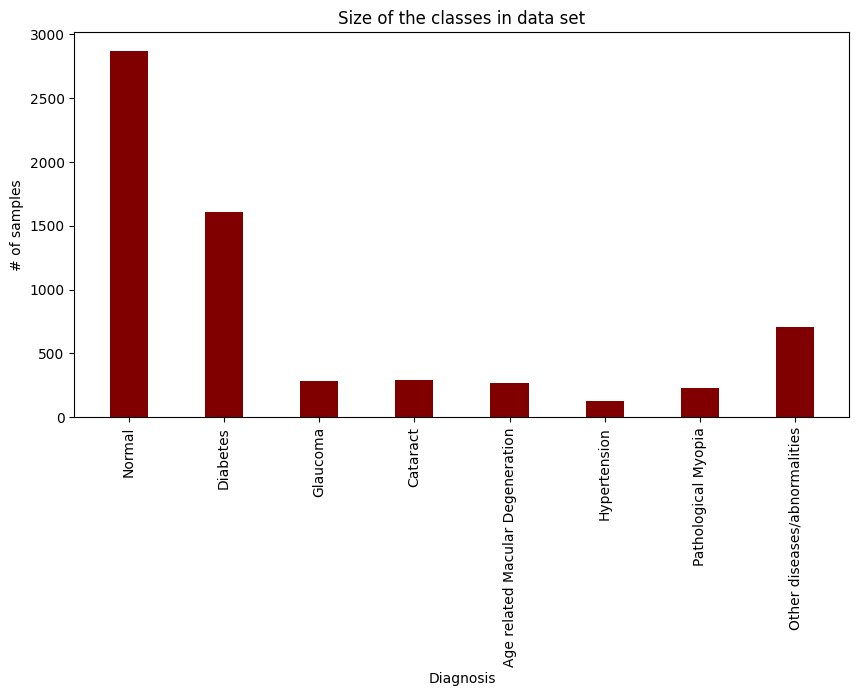

In [8]:
# 创建数据集
data = np.sum(targets, axis=0)

classes_names = list(classes.values())
values = list(data)
  
fig = plt.figure(figsize = (10, 5))
 
# 创建条形图
plt.bar(classes_names, values, color ='maroon',
        width = 0.4)
 
plt.xlabel("Diagnosis")
plt.ylabel("# of samples")
plt.title("Size of the classes in data set")

plt.xticks(rotation=90)

plt.show()

在此注意数据集是不平衡的，但是每个类别有超过 100 个样本图像，因此每个类别应该有足够的数据来训练分类问题。

### 1.4 各类别的绘图示例

In [9]:
img_dir = "./input/ocular-disease-recognition-odir5k/preprocessed_images"

In [10]:
raw_data["class_name"] = np.argmax(targets, axis=1).tolist()
raw_data["class_name"] = raw_data["class_name"] .replace(classes)

raw_data.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,filepath,target,filename,class_name
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,../input/ocular-disease-recognition-odir5k/ODI...,"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg,Normal
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,../input/ocular-disease-recognition-odir5k/ODI...,"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg,Normal
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,../input/ocular-disease-recognition-odir5k/ODI...,"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg,Diabetes
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,../input/ocular-disease-recognition-odir5k/ODI...,"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg,Diabetes
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,../input/ocular-disease-recognition-odir5k/ODI...,"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg,Diabetes


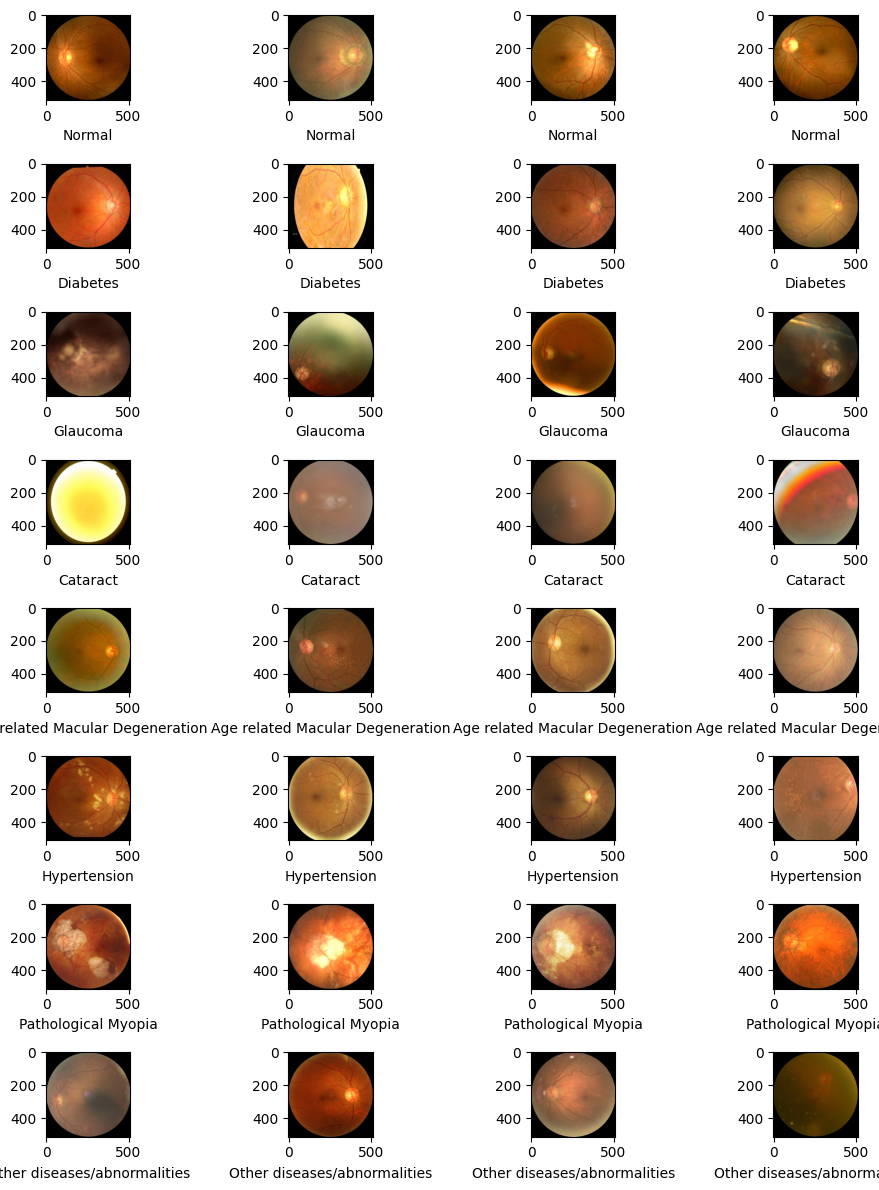

In [11]:
plt.figure(figsize=(12, 12))

for i, class_name in enumerate(classes.values()):
    
    class_subset = raw_data.loc[raw_data.class_name == class_name].sample(n=4)
    
    img_names = class_subset.filename.to_list()
    
    for j, img in enumerate(img_names):
        image = cv2.imread(os.path.join(img_dir, img))
        
        ## 转换图像为RGB格式
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        ## 子图变量subplot variables - （行数、列数、遍历网格上的位置）(# of rows, # of columns, iterate through locations on grid)
        plt.subplot(8, 4, 4 * i + j + 1)
        plt.imshow(image_rgb, aspect=1)
        
        ## 有文件名和诊断的标签
        plt.xlabel('{}'.format(class_name))

        plt.tight_layout() 

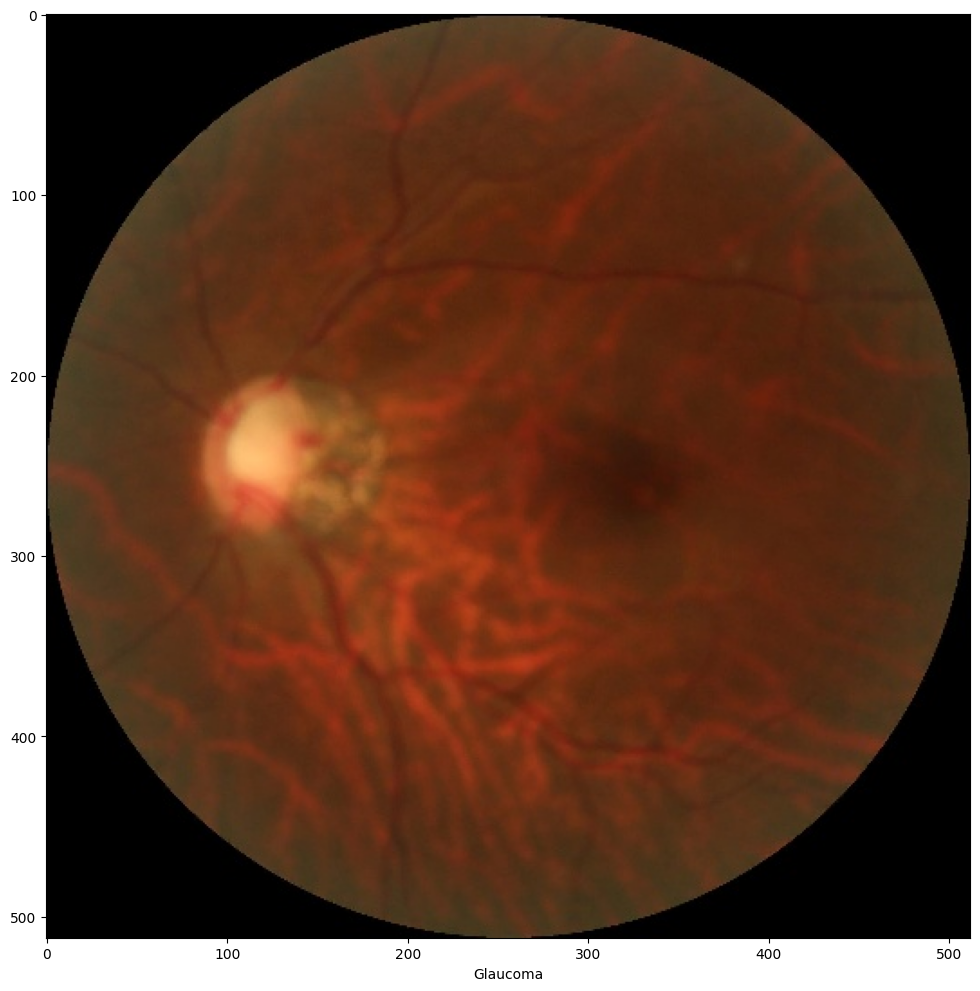

In [12]:
plt.figure(figsize=(12, 12))

single_class = ["Glaucoma"] #青光眼

for i, class_name in enumerate(single_class):
    
    class_subset = raw_data.loc[raw_data.class_name == class_name].sample(n=4)
    
    img_names = class_subset.filename.to_list()
    
    for j, img in enumerate(img_names):
        image = cv2.imread(os.path.join(img_dir, img))
        
        ## 转为rgb格式
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        ## 子图变量subplot variables - （行数、列数、遍历网格上的位置）(# of rows, # of columns, iterate through locations on grid)
        # plt.subplot(8, 4, 4 * i + j + 1)同上
        plt.imshow(image_rgb, aspect=1)
        
        ## 有文件名和诊断的标签
        plt.xlabel('{}'.format(class_name))

### 1.5 保存清洗好后的标签

In [13]:
processed_labels = raw_data[["ID", "filename", "class_name", "target"]]
processed_labels.to_csv('./working/labels_clean.csv', index=False)

processed_labels.head()

,ID,filename,class_name,target
0,0,0_right.jpg,Normal,"[1, 0, 0, 0, 0, 0, 0, 0]"
1,1,1_right.jpg,Normal,"[1, 0, 0, 0, 0, 0, 0, 0]"
2,2,2_right.jpg,Diabetes,"[0, 1, 0, 0, 0, 0, 0, 0]"
3,4,4_right.jpg,Diabetes,"[0, 1, 0, 0, 0, 0, 0, 0]"
4,5,5_right.jpg,Diabetes,"[0, 1, 0, 0, 0, 0, 0, 0]"


## 2. Import Libraries

In [14]:
# 导入库
import json
import os
import pickle
import random
import time

# 忽略警告
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

# PyTorch model
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from skimage import io, transform
# from sklearn.metrics import classification_report, confusion_matrix, jaccard_score
# from sklearn.model_selection import train_test_split
from torch.cuda.amp import autocast, GradScaler

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler

# PyTorch 数据集
from torchvision import datasets, models, transforms, utils
from torchvision.utils import make_grid

warnings.filterwarnings("ignore")

plt.ion()  # 交互模式

from __future__ import print_function, division

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [15]:
# 检查CUDA
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [16]:
!nvidia-smi

Mon Mar 31 23:50:55 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 572.83                 Driver Version: 572.83         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   48C    P0             25W /  140W |     373MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### 2.1 定义辅助函数

In [17]:
def test_network(net, trainloader):

    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)

    dataiter = iter(trainloader)
    images, labels = dataiter.next()

    # 为输入和目标创建变量
    inputs = Variable(images)
    targets = Variable(images)

    # 清除所有变量的梯度避免干扰
    optimizer.zero_grad()

    # 前向传递，然后后向传递，然后更新权重
    output = net.forward(inputs)
    loss = criterion(output, targets)
    loss.backward()
    optimizer.step()

    return True
#用于快速验证神经网络是否能完成一次完整的前向传播、反向传播和参数更新。避免因梯度爆炸/消失或数据加载错误导致训练失败

def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax
#将标准化后的张量图像反归一化并可视化。显示原始图像与增强后的对比，可检查数据增强（如随机裁剪、翻转）后图像是否失真

def view_recon(img, recon):
    ''' Function for displaying an image (as a PyTorch Tensor) and its
        reconstruction also a PyTorch Tensor
    '''

    fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True)
    axes[0].imshow(img.numpy().squeeze())
    axes[1].imshow(recon.data.numpy().squeeze())
    for ax in axes:
        ax.axis('off')
        ax.set_adjustable('box-forced')
#并排对比原始图像与模型重建图像
def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()
    #可视化图像及其预测概率分布

# 训练前：用 imshow 检查数据加载和增强效果，确保病变区域不被遮挡或扭曲。
# 训练中：用 test_network 验证单步训练稳定性，view_recon 监控自编码器重建质量。
# 训练后：用 view_classify 分析模型在测试集上的预测结果，识别易混淆疾病类

In [18]:
def show_images(image):
    """Show image"""
    plt.imshow(image)
    plt.pause(0.001)  # 暂停一下，以便更新图像

## 3. 定义 `OcularDiseaseRecognition` 类

In [19]:
class OcularDiseaseRecognition(Dataset):
    """Ocular Disease Recognition."""
#通过 CSV 文件（csv_file）读取患者 ID、图像路径和标签信息，并关联存储图像的根目录（root_dir）。
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with labels.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.labels_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.labels_frame.iloc[idx, 1])
        image = io.imread(img_name)
        target = self.labels_frame.iloc[idx, 3]
        target = np.array(json.loads(target))
        sample = {'image': image, 'labels': target}

        if self.transform:
            sample = self.transform(sample)

        return sample
    #ODIR-5K 中一个患者可能同时患有多种疾病（如糖尿病视网膜病变+高血压），通过 json.loads 解析标签字符串为数组，适配多标签分类任务的损失函数（如 BCEWithLogitsLoss）。

        
class Normalize(object):
    def __call__(self, sample):
        image, label = sample['image'], sample['labels']
        image = (image - image.min()) / (image.max() - image.min() + 1e-6)
        # 限制范围并转换类型
        return {
            'image': np.clip(image, 0, 1).astype(np.float32), 
            'labels': label
        }
###"""class Rescale(object):
    """将样本中的图像重新缩放为给定大小。

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    参数：
        output_size（元组或整数）：所需的输出大小。如果是元组，则输出与 output_size 匹配。如果是整数，则将较小的图像边缘与 output_size 匹配，同时保持纵横比不变。
    """

       # def __init__(self, output_size):
        #assert isinstance(output_size, (int, tuple))
       # self.output_size = output_size

       # def __call__(self, sample):
        #image = sample['image']
        # 强制缩放为512×512，使用双线性插值
       # image = cv2.resize(image, (512, 512), interpolation=cv2.INTER_LINEAR)
      #return {'image': image, 'labels': sample['labels']}"""###  
        
class RandomCrop(object):
    """随机裁剪样本中的图像。

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    参数：output_size（元组或整数）：所需的输出大小。如果是整数，则进行方形裁剪。
        
    """
#随机裁剪样本图像至固定尺寸（如 448x448）。增加模型对病灶位置变化的鲁棒性.小样本下需通过裁剪提升数据多样性。
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, label = sample['image'], sample['labels']
        h, w = image.shape[:2]
        
        # 计算目标尺寸
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h // w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w // h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)
        
        # 缩放并转换类型
        img = transform.resize(image, (new_h, new_w)).astype(np.float32)
        return {'image': img, 'labels': label}

class CenterCrop(object):
    """中心裁剪样本中的图像（保持病灶区域完整性）"""
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, label = sample['image'], sample['labels']
        h, w = image.shape[:2]
        new_h, new_w = self.output_size
        
        # 计算中心坐标
        top = (h - new_h) // 2
        left = (w - new_w) // 2

        image = image[top: top + new_h,
                      left: left + new_w]
        return {'image': image, 'labels': label}

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    def __call__(self, sample):
        image, label = sample['image'], sample['labels']
        
        # 动态处理通道维度
        if image.ndim == 2:  # 单通道灰度图 (H,W)
            image = np.expand_dims(image, axis=0)  # (C,H,W)
        else:  # 多通道图 (H,W,C)
            image = image.transpose((2, 0, 1))  # (C,H,W)
            
        return {
            'image': torch.from_numpy(image).float(),
            'labels': torch.from_numpy(label)
        }

## 4. 定义 Pytorch `Dataloader` & 加载数据

### 4.1 Load Labels

In [20]:
!pwd

'pwd' 不是内部或外部命令，也不是可运行的程序
或批处理文件。


In [21]:
labels = pd.read_csv('./working/labels_clean.csv')

n = 65
img_name = labels.iloc[n, 1]
class_name =  labels.iloc[n, 2]
target = labels.iloc[n, 3]

print('Image name: {}'.format(img_name))
print('Class Name: {}'.format(class_name))
print('Target: {}'.format(target))

Image name: 81_right.jpg
Class Name: Diabetes
Target: [0, 1, 0, 0, 0, 0, 0, 0]


In [22]:
labels.head(2)

,ID,filename,class_name,target
0,0,0_right.jpg,Normal,"[1, 0, 0, 0, 0, 0, 0, 0]"
1,1,1_right.jpg,Normal,"[1, 0, 0, 0, 0, 0, 0, 0]"


In [23]:
labels.shape

(6392, 4)

### 4.2 Load Image Data

In [24]:
# # 用于数据加载的子进程数
num_workers = 0
# 每批次要加载多少个样本
batch_size = 32
# 用于验证的训练集百分比
valid_size = 0.2
test_size = 0.2

In [25]:
# --------------------- 改进后的预处理流程 ---------------------
# 注意处理顺序对图像质量的影响
data_transforms = {
    'train': transforms.Compose([
        #Rescale(512),                    # 保持长宽比的缩放
        #RandomCrop(448),                 # 增强数据多样性
        Normalize(),                      # 新增：Min-Max归一化[4](@ref)
        ToTensor()                        # 张量转换
    ]),
    'val': transforms.Compose([
       # Rescale(512),
       # CenterCrop(448),                 # 验证集使用中心裁剪
        Normalize(),
        ToTensor()
    ])
}

# --------------------- 数据集初始化 ---------------------
full_data = OcularDiseaseRecognition(
    csv_file='./working/labels_clean.csv',
    root_dir='./input/ocular-disease-recognition-odir5k/preprocessed_images',
    transform=data_transforms['train']  # 根据模式选择预处理流程
)


In [26]:
# 获取用于验证的训练指标
num_train = len(full_data)
indices = list(range(num_train))

np.random.shuffle(indices)

val_split = int(np.floor(valid_size * num_train))
test_split = int(np.floor(valid_size * num_train))


test_idx, valid_idx, train_idx = indices[:test_split], indices[test_split: test_split + val_split], indices[test_split + val_split:]

In [27]:
num_train

6392

In [28]:
# 定义用于获取训练和验证批次的采样器
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler  = SubsetRandomSampler(test_idx)

In [29]:
# 准备数据加载器（结合数据集和采样器）
train_loader = torch.utils.data.DataLoader(full_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)

valid_loader = torch.utils.data.DataLoader(full_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)

test_loader = torch.utils.data.DataLoader(full_data, batch_size=batch_size, 
    sampler=test_sampler, num_workers=num_workers)

In [30]:
len(train_loader)

120

### 4.3 可视化一批训练数据

In [31]:
# 辅助函数来取消规范化并显示图像
def imshow(img):
    img = img / 2 + 0.5  # 反规范化
    plt.imshow(np.transpose(img, (1, 2, 0)))  # 从 Tensor 图像转换

In [32]:
# 获取一批训练图像
dataiter = iter(train_loader)
sample = next(dataiter)

sample['image'].shape # (number of examples: 20, number of channels: 3, pixel sizes: 256x256)示例数量：20，通道数量：3，像素大小：256x256

torch.Size([32, 3, 512, 512])

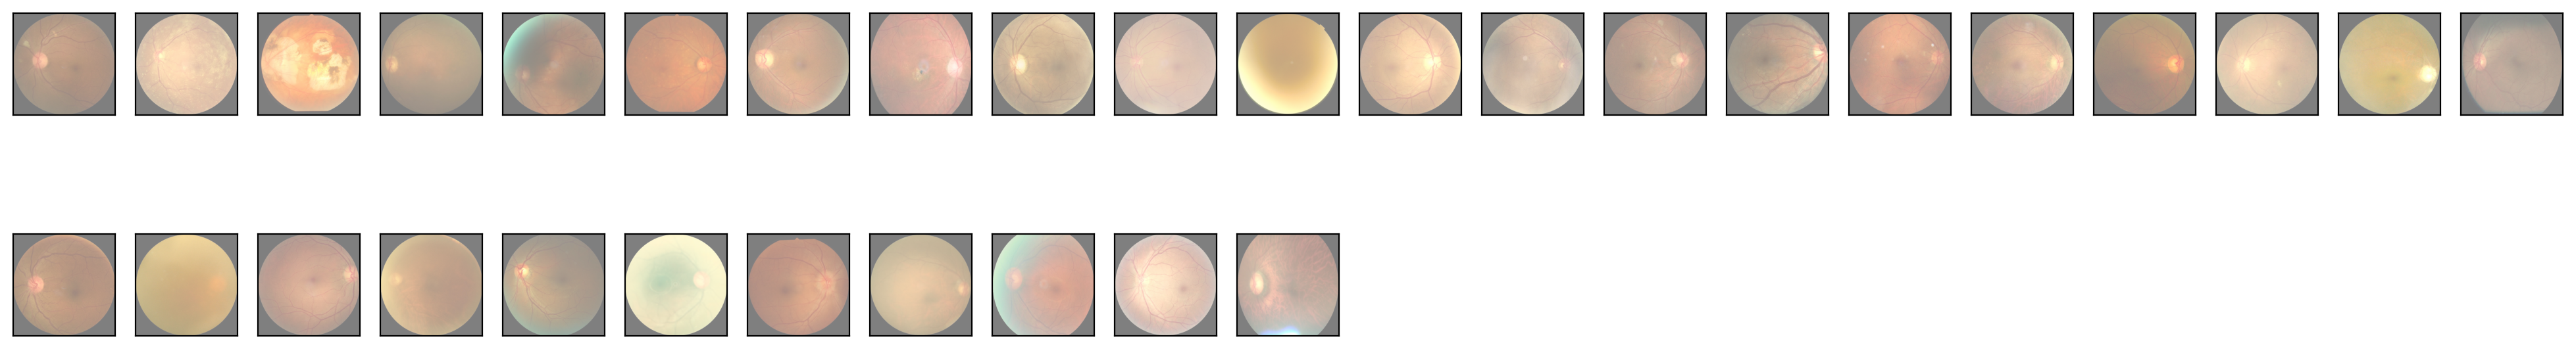

In [33]:
# 绘制批次中的图像以及相应的标签
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, 21, idx+1, xticks=[], yticks=[])
    imshow(sample['image'][idx])

## 5. 模型训练

In [34]:
device_name = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device_name)

print(device_name)

cuda


In [35]:
def save_checkpoint(state, is_best, filename='./working/bt_resnet50_ckpt_v2.pth.tar'):
    torch.save(state, filename)

### 5.1 定义模型架构

In [36]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import pandas as pd
import os
from skimage import io
import numpy as np
import json

class OcularDiseaseRecognition(Dataset):
    """眼科疾病识别数据集加载器"""
    
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): 带标注的CSV文件路径
            root_dir (string): 图像存储目录
            transform (callable, optional): 可选的数据预处理
        """
        self.labels_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        
        # 添加路径有效性验证
        self._validate_dataset()

    def __len__(self):
        return len(self.labels_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # 动态构建图像路径
        img_name = os.path.join(self.root_dir, 
                              self.labels_frame.iloc[idx, 1].strip())  # 第二列为文件名
        
        # 增强错误处理
        try:
            image = io.imread(img_name)
        except FileNotFoundError:
            print(f"文件缺失警告：{img_name}")
            return None  # 返回空值后续过滤
        
        # 标签处理
        target = self.labels_frame.iloc[idx, 3]
        target = np.array(json.loads(target), dtype=np.float32)
        
        sample = {'image': image, 'labels': target}
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample

    def _validate_dataset(self):
        """验证数据集完整性"""
        missing_files = []
        for idx in range(len(self)):
            img_path = os.path.join(self.root_dir, 
                                  self.labels_frame.iloc[idx, 1].strip())
            if not os.path.exists(img_path):
                missing_files.append(img_path)
        
        if missing_files:
            print(f"警告：共发现{len(missing_files)}个缺失文件，示例：{missing_files[:3]}")
            # 可根据需要自动过滤缺失项
            # self.labels_frame = self.labels_frame[~self.labels_frame.iloc[:,1].isin(missing_files)]



class ToTensor(object):
    """将numpy数组转换为张量"""
    
    def __call__(self, sample):
        image, labels = sample['image'], sample['labels']
        # 添加通道维度（若为灰度图）
        if len(image.shape) == 2:
            image = image[:, :, np.newaxis]
        # 转换维度顺序为 [C, H, W]
        image = image.transpose((2, 0, 1))
        return {
            'image': torch.from_numpy(image).float(),
            'labels': torch.from_numpy(labels).float()
        }

# 数据预处理流程
data_transforms = {
    'train': transforms.Compose([
        # 可添加更多数据增强操作
        # transforms.RandomHorizontalFlip(),
        # transforms.RandomRotation(15),
        ToTensor()
    ]),
    'val': transforms.Compose([
        ToTensor()
    ])
}

class StochasticDepth(nn.Module):
    """随机深度模块，用于缓解过拟合[1,3,4](@ref)"""
    def __init__(self, p=0.5):
        super().__init__()
        self.p = p  # 存活概率（注意：p=0.5表示50%概率保留）
        
    def forward(self, x):
        if not self.training:  # 测试阶段保持激活，但需调整权重
            return x * self.p
        
        # 训练阶段按伯努利分布随机丢弃
        if torch.rand(1).item() >= self.p:
            return x  # 保持激活
        
        # 返回零值但不阻断梯度传播[4](@ref)
        return x * 0
        
# 初始化完整数据集
full_dataset = OcularDiseaseRecognition(
    csv_file='./working/labels_clean.csv',
    root_dir='./input/ocular-disease-recognition-odir5k/preprocessed_images',
    transform=data_transforms['train']
)

# 过滤无效样本
full_dataset = [data for data in full_dataset if data is not None]

# 数据集划分（8:2比例）
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# 创建数据加载器
batch_size = 32
num_workers = 0 if torch.cuda.is_available() else 0

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)
# --------------------- 模型定义与微调 ---------------------
def build_improved_model(pretrained_weights_path, num_classes=8):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # 初始化ResNet50（禁用自动下载）
    model = models.resnet50(weights=None)
    
    # 加载本地预训练权重
    try:
        state_dict = torch.load(pretrained_weights_path, map_location=device)
        model.load_state_dict(state_dict)
        print("本地权重加载成功")
    except Exception as e:
        raise RuntimeError(f"权重加载失败：{str(e)}")

    # 冻结前4个阶段的参数（保留layer4可训练）
    for name, param in model.named_parameters():
        if 'layer4' not in name and 'fc' not in name:
            param.requires_grad = False

    # 重构全连接层
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(num_features, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        StochasticDepth(p=0.3),
        nn.Linear(512, num_classes)
    )

    # 多GPU训练适配
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)
        model = nn.SyncBatchNorm.convert_sync_batchnorm(model)
    
    model.to(device)
    return model

# 示例使用
if __name__ == "__main__":
    # 验证数据加载
    for i_batch, sample_batched in enumerate(train_loader):
        print(f"批次 {i_batch}:")
        print(f"图像尺寸: {sample_batched['image'].size()}")
        print(f"标签尺寸: {sample_batched['labels'].size()}")
        if i_batch == 1:  # 仅展示前两个批次
            break

批次 0:
图像尺寸: torch.Size([32, 3, 512, 512])
标签尺寸: torch.Size([32, 8])
批次 1:
图像尺寸: torch.Size([32, 3, 512, 512])
标签尺寸: torch.Size([32, 8])


In [37]:
# Limit maximum memory usage to 1GB

# torch.backends.cuda.reserved_memory = 4 * 1024 * 1024 * 1024
# torch.backends.cuda.max_allocated_memory = 4 * 1024 * 1024 * 1024
# 将最大内存使用量限制为 1GB

# torch.backends.cuda.reserved_memory = 4 * 1024 * 1024 * 1024
# torch.backends.cuda.max_allocated_memory = 4 * 1024 * 1024 * 1024

### 5.2 Define `Criterion` & `Optimizer`定义“标准”和“优化器”

In [38]:
# -------------------- 设备定义 --------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------- 模型初始化 --------------------
# 方案1：直接加载ResNet（示例）
# resnet_model = models.resnet50(pretrained=False)
# resnet_model.fc = nn.Linear(resnet_model.fc.in_features, 8)  # 修改输出层

# 方案2：使用自定义构建函数
resnet_model = build_improved_model(
    pretrained_weights_path='./input/resnet_50/resnet50-0676ba61.pth',
    num_classes=8
)
resnet_model = resnet_model.to(device)

# -------------------- 损失函数 --------------------
criterion = nn.CrossEntropyLoss().to(device)

# -------------------- 优化器 --------------------
optimizer = torch.optim.Adam(
    resnet_model.parameters(),  # 使用正确变量名
    lr=1e-4,
    weight_decay=1e-5
)

# -------------------- 训练记录器 --------------------
train_losses = []
test_losses = []
train_correct = []
test_correct = []

本地权重加载成功


### 5.3 运行训练循环

In [39]:
# 训练迭代次数
epochs = 250

In [40]:
torch.cuda.empty_cache()

In [41]:
# 设置训练开始时间
start_time = time.time()

# 将检查点阈值 best_prec 损失值设置为 2
best_prec1 = 2
is_best = False

# 空批次变量
b = None
train_b = None
test_b = None

scaler = GradScaler()

for i in range(epochs):
    # 每次迭代时清空训练正确计数器并测试正确计数器为 0
    trn_corr = 0
    tst_corr = 0
    trn_loss = 0
    tst_loss = 0
    
    # 设置循环的开始时间
    e_start = time.time()
    

    # 分批训练
    from tqdm import tqdm
    for b, sample in tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch: {i}"):
        # 如果设备是 cuda，则将标签设置为 cuda
        X, y = sample['image'].to(device, dtype=torch.float), sample['labels'].to(device, dtype=torch.float)
        
        # 前向传递图像样本
        y_pred = resnet_model(X.view(-1, 3, 512, 512))

        # 计算损失
        loss = criterion(y_pred.float(), y.float())

        trn_loss += loss.item()
        # 获取预测张量的 argmax，也就是我们的标签
        predicted = torch.argmax(y_pred, dim=1).data
        y = torch.argmax(y, dim=1).data

        # 如果预测标签与真实标签正确，则计算样本总和

        batch_corr = (predicted == y).sum()
        # 每批增量训练正确，并正确预测标签
        trn_corr += batch_corr.item()
        
        # 将优化器梯度设置为零
        optimizer.zero_grad()
        # 通过自动广播进行反向传播
        # 带损失反向传播
        scaler.scale(loss).backward()
        # 执行优化器步骤
        scaler.step(optimizer)
        scaler.update()
      
    # 设置循环的结束时间
    e_end = time.time()
    
    # print training metrics
    print(f'Epoch {(i+1)} Batch {(b+1)}\nAccuracy: {trn_corr*100/(b*batch_size):2.2f} %  Loss: {trn_loss/len(train_loader):2.4f}  Duration: {((e_end-e_start)/60):.2f} minutes') 
    
    # 一些用于可视化的指标存储
    train_b = b
    train_losses.append(trn_loss)
    train_correct.append(trn_corr)

    X, y = None, None

    # 使用验证生成器进行验证
    # 验证时不执行任何梯度更新 
    with torch.no_grad():
        for b, sample in enumerate(valid_loader):
            # 如果设备是 cuda，则将标签设置为 cuda
            X, y = sample['image'].to(device, dtype=torch.float), sample['labels'].to(device, dtype=torch.float)

            # 前向传递图像
            y_val = resnet_model(X.view(-1, 3, 512, 512))

            # 获取预测张量的 argmax，也就是我们的标签
            predicted = torch.argmax(y_val, dim=1).data
            y = torch.argmax(y, dim=1).data

            # 每批增量测试正确，并正确预测标签
            tst_corr += (predicted == y).sum().item()

            # 获得验证集损失
            loss = criterion(y_val.float(), y.long())
            tst_loss += loss.item()
            
            
    # 打印验证指标
    print(f'Validation Accuracy {tst_corr*100/(b*batch_size):2.2f}% Validation Loss: {tst_loss/len(valid_loader):2.4f}\n')

    # 如果当前验证损失小于前几次迭代验证损失，则创建并保存检查点
    is_best = loss < best_prec1
    best_prec1 = min(loss, best_prec1)
    
    if is_best:
        save_checkpoint({
                'epoch': i + 1,
                'state_dict': resnet_model.state_dict(),
                'best_prec1': best_prec1,
            }, is_best)
        
        is_best = False

    # 一些用于可视化的指标存储
    test_b  = b
    test_losses.append(tst_loss)
    test_correct.append(tst_corr)

# 设置总训练的结束时间
end_time = time.time() - start_time    

# 打印培训摘要
print("\nTraining Duration {:.2f} minutes".format(end_time/60))
print("GPU memory used : {} kb".format(torch.cuda.memory_allocated()))
print("GPU memory cached : {} kb".format(torch.cuda.memory_cached()))

Epoch: 0: 100%|██████████| 160/160 [01:39<00:00,  1.61it/s]


Epoch 1 Batch 160
Accuracy: 37.48 %  Loss: 1.6444  Duration: 1.66 minutes
Validation Accuracy 43.11% Validation Loss: 1.4930



Epoch: 1: 100%|██████████| 160/160 [01:17<00:00,  2.06it/s]


Epoch 2 Batch 160
Accuracy: 51.75 %  Loss: 1.3017  Duration: 1.30 minutes
Validation Accuracy 50.80% Validation Loss: 1.2688



Epoch: 2: 100%|██████████| 160/160 [01:16<00:00,  2.10it/s]


Epoch 3 Batch 160
Accuracy: 54.01 %  Loss: 1.1840  Duration: 1.27 minutes
Validation Accuracy 57.61% Validation Loss: 1.1588



Epoch: 3: 100%|██████████| 160/160 [01:14<00:00,  2.14it/s]


Epoch 4 Batch 160
Accuracy: 62.54 %  Loss: 1.1414  Duration: 1.24 minutes
Validation Accuracy 67.95% Validation Loss: 1.1118



Epoch: 4: 100%|██████████| 160/160 [01:14<00:00,  2.14it/s]


Epoch 5 Batch 160
Accuracy: 74.23 %  Loss: 0.9129  Duration: 1.25 minutes
Validation Accuracy 78.21% Validation Loss: 0.8293



Epoch: 5: 100%|██████████| 160/160 [01:15<00:00,  2.12it/s]


Epoch 6 Batch 160
Accuracy: 73.84 %  Loss: 0.9409  Duration: 1.26 minutes
Validation Accuracy 78.77% Validation Loss: 0.8076



Epoch: 6: 100%|██████████| 160/160 [01:15<00:00,  2.11it/s]


Epoch 7 Batch 160
Accuracy: 78.77 %  Loss: 0.7810  Duration: 1.26 minutes
Validation Accuracy 80.93% Validation Loss: 0.7706



Epoch: 7: 100%|██████████| 160/160 [01:14<00:00,  2.15it/s]


Epoch 8 Batch 160
Accuracy: 79.95 %  Loss: 0.7617  Duration: 1.24 minutes
Validation Accuracy 72.28% Validation Loss: 1.1050



Epoch: 8: 100%|██████████| 160/160 [01:14<00:00,  2.16it/s]


Epoch 9 Batch 160
Accuracy: 83.27 %  Loss: 0.6393  Duration: 1.24 minutes
Validation Accuracy 76.60% Validation Loss: 0.8587



Epoch: 9: 100%|██████████| 160/160 [01:16<00:00,  2.10it/s]


Epoch 10 Batch 160
Accuracy: 81.70 %  Loss: 0.6818  Duration: 1.27 minutes
Validation Accuracy 78.37% Validation Loss: 0.8357



Epoch: 10: 100%|██████████| 160/160 [01:15<00:00,  2.12it/s]


Epoch 11 Batch 160
Accuracy: 80.74 %  Loss: 0.7232  Duration: 1.26 minutes
Validation Accuracy 80.05% Validation Loss: 0.8423



Epoch: 11: 100%|██████████| 160/160 [01:16<00:00,  2.08it/s]


Epoch 12 Batch 160
Accuracy: 82.90 %  Loss: 0.6586  Duration: 1.28 minutes
Validation Accuracy 84.86% Validation Loss: 0.6441



Epoch: 12: 100%|██████████| 160/160 [01:14<00:00,  2.16it/s]


Epoch 13 Batch 160
Accuracy: 85.40 %  Loss: 0.5541  Duration: 1.23 minutes
Validation Accuracy 79.41% Validation Loss: 0.8207



Epoch: 13: 100%|██████████| 160/160 [01:13<00:00,  2.16it/s]


Epoch 14 Batch 160
Accuracy: 83.79 %  Loss: 0.6142  Duration: 1.23 minutes
Validation Accuracy 74.92% Validation Loss: 0.9616



Epoch: 14: 100%|██████████| 160/160 [01:15<00:00,  2.12it/s]


Epoch 15 Batch 160
Accuracy: 84.32 %  Loss: 0.5823  Duration: 1.26 minutes
Validation Accuracy 84.13% Validation Loss: 0.6969



Epoch: 15: 100%|██████████| 160/160 [01:14<00:00,  2.15it/s]


Epoch 16 Batch 160
Accuracy: 82.49 %  Loss: 0.6495  Duration: 1.24 minutes
Validation Accuracy 81.25% Validation Loss: 0.7401



Epoch: 16: 100%|██████████| 160/160 [01:14<00:00,  2.15it/s]


Epoch 17 Batch 160
Accuracy: 78.58 %  Loss: 0.7744  Duration: 1.24 minutes
Validation Accuracy 75.88% Validation Loss: 0.9986



Epoch: 17: 100%|██████████| 160/160 [01:14<00:00,  2.14it/s]


Epoch 18 Batch 160
Accuracy: 83.92 %  Loss: 0.5947  Duration: 1.24 minutes
Validation Accuracy 80.21% Validation Loss: 0.8046



Epoch: 18: 100%|██████████| 160/160 [01:15<00:00,  2.11it/s]


Epoch 19 Batch 160
Accuracy: 86.46 %  Loss: 0.5121  Duration: 1.27 minutes
Validation Accuracy 88.14% Validation Loss: 0.5925



Epoch: 19: 100%|██████████| 160/160 [01:17<00:00,  2.08it/s]


Epoch 20 Batch 160
Accuracy: 85.34 %  Loss: 0.5417  Duration: 1.28 minutes
Validation Accuracy 83.65% Validation Loss: 0.6960



Epoch: 20: 100%|██████████| 160/160 [01:14<00:00,  2.14it/s]


Epoch 21 Batch 160
Accuracy: 83.41 %  Loss: 0.5984  Duration: 1.25 minutes
Validation Accuracy 80.77% Validation Loss: 0.8064



Epoch: 21: 100%|██████████| 160/160 [01:13<00:00,  2.17it/s]


Epoch 22 Batch 160
Accuracy: 85.28 %  Loss: 0.5378  Duration: 1.23 minutes
Validation Accuracy 75.56% Validation Loss: 0.9502



Epoch: 22: 100%|██████████| 160/160 [01:13<00:00,  2.18it/s]


Epoch 23 Batch 160
Accuracy: 83.25 %  Loss: 0.6263  Duration: 1.22 minutes
Validation Accuracy 80.29% Validation Loss: 0.7563



Epoch: 23: 100%|██████████| 160/160 [01:14<00:00,  2.16it/s]


Epoch 24 Batch 160
Accuracy: 82.25 %  Loss: 0.6380  Duration: 1.23 minutes
Validation Accuracy 83.01% Validation Loss: 0.7503



Epoch: 24: 100%|██████████| 160/160 [01:14<00:00,  2.14it/s]


Epoch 25 Batch 160
Accuracy: 81.11 %  Loss: 0.6802  Duration: 1.25 minutes
Validation Accuracy 77.16% Validation Loss: 0.8845



Epoch: 25: 100%|██████████| 160/160 [01:13<00:00,  2.17it/s]


Epoch 26 Batch 160
Accuracy: 79.13 %  Loss: 0.7341  Duration: 1.23 minutes
Validation Accuracy 80.53% Validation Loss: 0.8011



Epoch: 26: 100%|██████████| 160/160 [01:14<00:00,  2.16it/s]


Epoch 27 Batch 160
Accuracy: 83.81 %  Loss: 0.5964  Duration: 1.23 minutes
Validation Accuracy 74.76% Validation Loss: 1.0403



Epoch: 27: 100%|██████████| 160/160 [01:14<00:00,  2.14it/s]


Epoch 28 Batch 160
Accuracy: 83.86 %  Loss: 0.5778  Duration: 1.25 minutes
Validation Accuracy 78.04% Validation Loss: 0.9003



Epoch: 28: 100%|██████████| 160/160 [01:15<00:00,  2.12it/s]


Epoch 29 Batch 160
Accuracy: 81.25 %  Loss: 0.6510  Duration: 1.26 minutes
Validation Accuracy 76.68% Validation Loss: 0.9492



Epoch: 29: 100%|██████████| 160/160 [01:13<00:00,  2.17it/s]


Epoch 30 Batch 160
Accuracy: 82.08 %  Loss: 0.6584  Duration: 1.23 minutes
Validation Accuracy 85.50% Validation Loss: 0.6783



Epoch: 30: 100%|██████████| 160/160 [01:15<00:00,  2.11it/s]


Epoch 31 Batch 160
Accuracy: 82.49 %  Loss: 0.6146  Duration: 1.26 minutes
Validation Accuracy 77.32% Validation Loss: 0.9161



Epoch: 31: 100%|██████████| 160/160 [01:14<00:00,  2.15it/s]


Epoch 32 Batch 160
Accuracy: 86.12 %  Loss: 0.4948  Duration: 1.24 minutes
Validation Accuracy 75.48% Validation Loss: 0.9738



Epoch: 32: 100%|██████████| 160/160 [01:14<00:00,  2.15it/s]


Epoch 33 Batch 160
Accuracy: 79.30 %  Loss: 0.7211  Duration: 1.24 minutes
Validation Accuracy 74.60% Validation Loss: 0.9752



Epoch: 33: 100%|██████████| 160/160 [01:13<00:00,  2.17it/s]


Epoch 34 Batch 160
Accuracy: 83.18 %  Loss: 0.5958  Duration: 1.23 minutes
Validation Accuracy 78.12% Validation Loss: 0.8713



Epoch: 34: 100%|██████████| 160/160 [01:14<00:00,  2.15it/s]


Epoch 35 Batch 160
Accuracy: 84.93 %  Loss: 0.5411  Duration: 1.24 minutes
Validation Accuracy 71.88% Validation Loss: 1.1079



Epoch: 35: 100%|██████████| 160/160 [01:17<00:00,  2.07it/s]


Epoch 36 Batch 160
Accuracy: 83.94 %  Loss: 0.5553  Duration: 1.29 minutes
Validation Accuracy 79.57% Validation Loss: 0.7880



Epoch: 36: 100%|██████████| 160/160 [01:14<00:00,  2.15it/s]


Epoch 37 Batch 160
Accuracy: 84.98 %  Loss: 0.5290  Duration: 1.24 minutes
Validation Accuracy 77.72% Validation Loss: 0.8145



Epoch: 37: 100%|██████████| 160/160 [01:13<00:00,  2.17it/s]


Epoch 38 Batch 160
Accuracy: 86.93 %  Loss: 0.4717  Duration: 1.23 minutes
Validation Accuracy 81.57% Validation Loss: 0.8294



Epoch: 38: 100%|██████████| 160/160 [01:14<00:00,  2.14it/s]


Epoch 39 Batch 160
Accuracy: 80.58 %  Loss: 0.6690  Duration: 1.25 minutes
Validation Accuracy 78.93% Validation Loss: 0.8560



Epoch: 39: 100%|██████████| 160/160 [01:15<00:00,  2.11it/s]


Epoch 40 Batch 160
Accuracy: 83.59 %  Loss: 0.5551  Duration: 1.26 minutes
Validation Accuracy 85.98% Validation Loss: 0.6420



Epoch: 40: 100%|██████████| 160/160 [01:15<00:00,  2.13it/s]


Epoch 41 Batch 160
Accuracy: 80.42 %  Loss: 0.6773  Duration: 1.25 minutes
Validation Accuracy 81.25% Validation Loss: 0.7440



Epoch: 41: 100%|██████████| 160/160 [01:16<00:00,  2.09it/s]


Epoch 42 Batch 160
Accuracy: 80.33 %  Loss: 0.6713  Duration: 1.28 minutes
Validation Accuracy 81.33% Validation Loss: 0.7569



Epoch: 42: 100%|██████████| 160/160 [01:18<00:00,  2.03it/s]


Epoch 43 Batch 160
Accuracy: 85.40 %  Loss: 0.4887  Duration: 1.32 minutes
Validation Accuracy 82.69% Validation Loss: 0.7448



Epoch: 43: 100%|██████████| 160/160 [01:13<00:00,  2.17it/s]


Epoch 44 Batch 160
Accuracy: 81.76 %  Loss: 0.6410  Duration: 1.23 minutes
Validation Accuracy 77.48% Validation Loss: 0.8399



Epoch: 44: 100%|██████████| 160/160 [01:14<00:00,  2.15it/s]


Epoch 45 Batch 160
Accuracy: 84.06 %  Loss: 0.5380  Duration: 1.24 minutes
Validation Accuracy 76.52% Validation Loss: 0.9347



Epoch: 45: 100%|██████████| 160/160 [01:15<00:00,  2.12it/s]


Epoch 46 Batch 160
Accuracy: 84.53 %  Loss: 0.5396  Duration: 1.26 minutes
Validation Accuracy 69.55% Validation Loss: 1.1098



Epoch: 46: 100%|██████████| 160/160 [01:14<00:00,  2.14it/s]


Epoch 47 Batch 160
Accuracy: 82.94 %  Loss: 0.5719  Duration: 1.25 minutes
Validation Accuracy 81.33% Validation Loss: 0.7571



Epoch: 47: 100%|██████████| 160/160 [01:14<00:00,  2.16it/s]


Epoch 48 Batch 160
Accuracy: 84.61 %  Loss: 0.5277  Duration: 1.23 minutes
Validation Accuracy 79.73% Validation Loss: 0.7969



Epoch: 48: 100%|██████████| 160/160 [01:16<00:00,  2.10it/s]


Epoch 49 Batch 160
Accuracy: 81.56 %  Loss: 0.6145  Duration: 1.27 minutes
Validation Accuracy 76.44% Validation Loss: 0.9656



Epoch: 49: 100%|██████████| 160/160 [01:17<00:00,  2.06it/s]


Epoch 50 Batch 160
Accuracy: 83.86 %  Loss: 0.5454  Duration: 1.29 minutes
Validation Accuracy 84.78% Validation Loss: 0.6638



Epoch: 50: 100%|██████████| 160/160 [01:17<00:00,  2.06it/s]


Epoch 51 Batch 160
Accuracy: 83.84 %  Loss: 0.5408  Duration: 1.29 minutes
Validation Accuracy 81.01% Validation Loss: 0.7820



Epoch: 51: 100%|██████████| 160/160 [01:14<00:00,  2.15it/s]


Epoch 52 Batch 160
Accuracy: 89.37 %  Loss: 0.3807  Duration: 1.24 minutes
Validation Accuracy 83.17% Validation Loss: 0.7296



Epoch: 52: 100%|██████████| 160/160 [01:15<00:00,  2.13it/s]


Epoch 53 Batch 160
Accuracy: 82.88 %  Loss: 0.5666  Duration: 1.25 minutes
Validation Accuracy 78.45% Validation Loss: 0.9041



Epoch: 53: 100%|██████████| 160/160 [01:13<00:00,  2.18it/s]


Epoch 54 Batch 160
Accuracy: 83.43 %  Loss: 0.5627  Duration: 1.22 minutes
Validation Accuracy 81.97% Validation Loss: 0.7472



Epoch: 54: 100%|██████████| 160/160 [01:14<00:00,  2.14it/s]


Epoch 55 Batch 160
Accuracy: 81.66 %  Loss: 0.6081  Duration: 1.25 minutes
Validation Accuracy 79.57% Validation Loss: 0.8026



Epoch: 55: 100%|██████████| 160/160 [01:13<00:00,  2.17it/s]


Epoch 56 Batch 160
Accuracy: 80.21 %  Loss: 0.6629  Duration: 1.23 minutes
Validation Accuracy 81.17% Validation Loss: 0.7770



Epoch: 56: 100%|██████████| 160/160 [01:15<00:00,  2.11it/s]


Epoch 57 Batch 160
Accuracy: 81.68 %  Loss: 0.5916  Duration: 1.26 minutes
Validation Accuracy 77.16% Validation Loss: 0.9362



Epoch: 57: 100%|██████████| 160/160 [01:14<00:00,  2.16it/s]


Epoch 58 Batch 160
Accuracy: 85.04 %  Loss: 0.4870  Duration: 1.24 minutes
Validation Accuracy 81.25% Validation Loss: 0.7621



Epoch: 58: 100%|██████████| 160/160 [01:15<00:00,  2.13it/s]


Epoch 59 Batch 160
Accuracy: 79.36 %  Loss: 0.6689  Duration: 1.25 minutes
Validation Accuracy 81.17% Validation Loss: 0.7850



Epoch: 59: 100%|██████████| 160/160 [01:15<00:00,  2.12it/s]


Epoch 60 Batch 160
Accuracy: 87.15 %  Loss: 0.4408  Duration: 1.26 minutes
Validation Accuracy 84.05% Validation Loss: 0.7308



Epoch: 60: 100%|██████████| 160/160 [01:14<00:00,  2.14it/s]


Epoch 61 Batch 160
Accuracy: 86.28 %  Loss: 0.4616  Duration: 1.25 minutes
Validation Accuracy 82.45% Validation Loss: 0.7722



Epoch: 61: 100%|██████████| 160/160 [01:17<00:00,  2.07it/s]


Epoch 62 Batch 160
Accuracy: 82.57 %  Loss: 0.5739  Duration: 1.29 minutes
Validation Accuracy 73.64% Validation Loss: 0.9593



Epoch: 62: 100%|██████████| 160/160 [01:14<00:00,  2.14it/s]


Epoch 63 Batch 160
Accuracy: 85.38 %  Loss: 0.4789  Duration: 1.25 minutes
Validation Accuracy 77.64% Validation Loss: 0.8719



Epoch: 63: 100%|██████████| 160/160 [01:13<00:00,  2.19it/s]


Epoch 64 Batch 160
Accuracy: 82.10 %  Loss: 0.5930  Duration: 1.22 minutes
Validation Accuracy 80.61% Validation Loss: 0.8015



Epoch: 64: 100%|██████████| 160/160 [01:14<00:00,  2.15it/s]


Epoch 65 Batch 160
Accuracy: 85.12 %  Loss: 0.4853  Duration: 1.24 minutes
Validation Accuracy 80.93% Validation Loss: 0.7970



Epoch: 65: 100%|██████████| 160/160 [01:14<00:00,  2.14it/s]


Epoch 66 Batch 160
Accuracy: 81.62 %  Loss: 0.5950  Duration: 1.24 minutes
Validation Accuracy 78.29% Validation Loss: 0.8971



Epoch: 66: 100%|██████████| 160/160 [01:13<00:00,  2.17it/s]


Epoch 67 Batch 160
Accuracy: 86.07 %  Loss: 0.4510  Duration: 1.23 minutes
Validation Accuracy 85.18% Validation Loss: 0.6822



Epoch: 67: 100%|██████████| 160/160 [01:18<00:00,  2.05it/s]


Epoch 68 Batch 160
Accuracy: 86.12 %  Loss: 0.4610  Duration: 1.30 minutes
Validation Accuracy 77.64% Validation Loss: 0.8958



Epoch: 68: 100%|██████████| 160/160 [01:19<00:00,  2.02it/s]


Epoch 69 Batch 160
Accuracy: 83.47 %  Loss: 0.5341  Duration: 1.32 minutes
Validation Accuracy 83.01% Validation Loss: 0.7413



Epoch: 69: 100%|██████████| 160/160 [01:14<00:00,  2.16it/s]


Epoch 70 Batch 160
Accuracy: 79.72 %  Loss: 0.6424  Duration: 1.24 minutes
Validation Accuracy 80.29% Validation Loss: 0.8358



Epoch: 70: 100%|██████████| 160/160 [01:14<00:00,  2.15it/s]


Epoch 71 Batch 160
Accuracy: 84.67 %  Loss: 0.4989  Duration: 1.24 minutes
Validation Accuracy 81.89% Validation Loss: 0.7602



Epoch: 71: 100%|██████████| 160/160 [01:14<00:00,  2.14it/s]


Epoch 72 Batch 160
Accuracy: 84.04 %  Loss: 0.5196  Duration: 1.25 minutes
Validation Accuracy 72.76% Validation Loss: 0.9990



Epoch: 72: 100%|██████████| 160/160 [01:14<00:00,  2.13it/s]


Epoch 73 Batch 160
Accuracy: 85.85 %  Loss: 0.4720  Duration: 1.25 minutes
Validation Accuracy 79.17% Validation Loss: 0.8701



Epoch: 73: 100%|██████████| 160/160 [01:17<00:00,  2.08it/s]


Epoch 74 Batch 160
Accuracy: 85.02 %  Loss: 0.4728  Duration: 1.28 minutes
Validation Accuracy 81.33% Validation Loss: 0.7820



Epoch: 74: 100%|██████████| 160/160 [01:16<00:00,  2.09it/s]


Epoch 75 Batch 160
Accuracy: 85.48 %  Loss: 0.4979  Duration: 1.28 minutes
Validation Accuracy 80.85% Validation Loss: 0.8040



Epoch: 75: 100%|██████████| 160/160 [01:14<00:00,  2.15it/s]


Epoch 76 Batch 160
Accuracy: 84.55 %  Loss: 0.4967  Duration: 1.24 minutes
Validation Accuracy 77.56% Validation Loss: 0.9149



Epoch: 76: 100%|██████████| 160/160 [01:13<00:00,  2.16it/s]


Epoch 77 Batch 160
Accuracy: 81.90 %  Loss: 0.5734  Duration: 1.23 minutes
Validation Accuracy 72.04% Validation Loss: 1.0312



Epoch: 77: 100%|██████████| 160/160 [01:14<00:00,  2.15it/s]


Epoch 78 Batch 160
Accuracy: 85.48 %  Loss: 0.4670  Duration: 1.24 minutes
Validation Accuracy 79.73% Validation Loss: 0.8230



Epoch: 78: 100%|██████████| 160/160 [01:14<00:00,  2.14it/s]


Epoch 79 Batch 160
Accuracy: 82.76 %  Loss: 0.5548  Duration: 1.25 minutes
Validation Accuracy 81.33% Validation Loss: 0.7659



Epoch: 79: 100%|██████████| 160/160 [01:14<00:00,  2.16it/s]


Epoch 80 Batch 160
Accuracy: 84.10 %  Loss: 0.5059  Duration: 1.24 minutes
Validation Accuracy 77.32% Validation Loss: 0.8613



Epoch: 80: 100%|██████████| 160/160 [01:13<00:00,  2.19it/s]


Epoch 81 Batch 160
Accuracy: 81.98 %  Loss: 0.5625  Duration: 1.22 minutes
Validation Accuracy 78.61% Validation Loss: 0.7746



Epoch: 81: 100%|██████████| 160/160 [01:15<00:00,  2.11it/s]


Epoch 82 Batch 160
Accuracy: 83.43 %  Loss: 0.5254  Duration: 1.26 minutes
Validation Accuracy 80.13% Validation Loss: 0.8803



Epoch: 82: 100%|██████████| 160/160 [01:14<00:00,  2.14it/s]


Epoch 83 Batch 160
Accuracy: 84.12 %  Loss: 0.5063  Duration: 1.25 minutes
Validation Accuracy 77.16% Validation Loss: 0.8636



Epoch: 83: 100%|██████████| 160/160 [01:16<00:00,  2.08it/s]


Epoch 84 Batch 160
Accuracy: 83.86 %  Loss: 0.5204  Duration: 1.28 minutes
Validation Accuracy 81.89% Validation Loss: 0.7778



Epoch: 84: 100%|██████████| 160/160 [01:15<00:00,  2.11it/s]


Epoch 85 Batch 160
Accuracy: 84.24 %  Loss: 0.5021  Duration: 1.26 minutes
Validation Accuracy 77.40% Validation Loss: 0.9188



Epoch: 85: 100%|██████████| 160/160 [01:14<00:00,  2.16it/s]


Epoch 86 Batch 160
Accuracy: 87.19 %  Loss: 0.4165  Duration: 1.24 minutes
Validation Accuracy 81.57% Validation Loss: 0.7850



Epoch: 86: 100%|██████████| 160/160 [01:13<00:00,  2.16it/s]


Epoch 87 Batch 160
Accuracy: 81.92 %  Loss: 0.5820  Duration: 1.23 minutes
Validation Accuracy 83.65% Validation Loss: 0.6810



Epoch: 87: 100%|██████████| 160/160 [01:13<00:00,  2.16it/s]


Epoch 88 Batch 160
Accuracy: 80.21 %  Loss: 0.6184  Duration: 1.23 minutes
Validation Accuracy 71.96% Validation Loss: 0.9814



Epoch: 88: 100%|██████████| 160/160 [01:14<00:00,  2.15it/s]


Epoch 89 Batch 160
Accuracy: 84.89 %  Loss: 0.4896  Duration: 1.24 minutes
Validation Accuracy 76.12% Validation Loss: 0.8138



Epoch: 89: 100%|██████████| 160/160 [01:15<00:00,  2.12it/s]


Epoch 90 Batch 160
Accuracy: 82.51 %  Loss: 0.5366  Duration: 1.26 minutes
Validation Accuracy 77.08% Validation Loss: 0.8945



Epoch: 90: 100%|██████████| 160/160 [01:15<00:00,  2.11it/s]


Epoch 91 Batch 160
Accuracy: 85.48 %  Loss: 0.4629  Duration: 1.26 minutes
Validation Accuracy 76.68% Validation Loss: 0.9069



Epoch: 91: 100%|██████████| 160/160 [01:14<00:00,  2.15it/s]


Epoch 92 Batch 160
Accuracy: 80.66 %  Loss: 0.6008  Duration: 1.24 minutes
Validation Accuracy 76.36% Validation Loss: 0.8962



Epoch: 92: 100%|██████████| 160/160 [01:15<00:00,  2.11it/s]


Epoch 93 Batch 160
Accuracy: 84.75 %  Loss: 0.4788  Duration: 1.26 minutes
Validation Accuracy 76.12% Validation Loss: 0.9790



Epoch: 93: 100%|██████████| 160/160 [01:13<00:00,  2.19it/s]


Epoch 94 Batch 160
Accuracy: 83.88 %  Loss: 0.5092  Duration: 1.22 minutes
Validation Accuracy 78.61% Validation Loss: 0.8070



Epoch: 94: 100%|██████████| 160/160 [01:13<00:00,  2.18it/s]


Epoch 95 Batch 160
Accuracy: 81.74 %  Loss: 0.5622  Duration: 1.23 minutes
Validation Accuracy 79.57% Validation Loss: 0.8517



Epoch: 95: 100%|██████████| 160/160 [01:14<00:00,  2.14it/s]


Epoch 96 Batch 160
Accuracy: 80.82 %  Loss: 0.5919  Duration: 1.25 minutes
Validation Accuracy 77.88% Validation Loss: 0.8558



Epoch: 96: 100%|██████████| 160/160 [01:18<00:00,  2.05it/s]


Epoch 97 Batch 160
Accuracy: 85.97 %  Loss: 0.4406  Duration: 1.30 minutes
Validation Accuracy 81.09% Validation Loss: 0.7387



Epoch: 97: 100%|██████████| 160/160 [01:16<00:00,  2.09it/s]


Epoch 98 Batch 160
Accuracy: 85.57 %  Loss: 0.4486  Duration: 1.27 minutes
Validation Accuracy 84.13% Validation Loss: 0.7629



Epoch: 98: 100%|██████████| 160/160 [01:14<00:00,  2.14it/s]


Epoch 99 Batch 160
Accuracy: 85.63 %  Loss: 0.4428  Duration: 1.25 minutes
Validation Accuracy 79.41% Validation Loss: 0.8235



Epoch: 99: 100%|██████████| 160/160 [01:16<00:00,  2.10it/s]


Epoch 100 Batch 160
Accuracy: 83.86 %  Loss: 0.4977  Duration: 1.27 minutes
Validation Accuracy 80.85% Validation Loss: 0.7533



Epoch: 100: 100%|██████████| 160/160 [01:17<00:00,  2.06it/s]


Epoch 101 Batch 160
Accuracy: 77.10 %  Loss: 0.6766  Duration: 1.29 minutes
Validation Accuracy 73.56% Validation Loss: 0.9541



Epoch: 101: 100%|██████████| 160/160 [01:18<00:00,  2.03it/s]


Epoch 102 Batch 160
Accuracy: 82.19 %  Loss: 0.5505  Duration: 1.31 minutes
Validation Accuracy 77.40% Validation Loss: 0.8581



Epoch: 102: 100%|██████████| 160/160 [01:17<00:00,  2.06it/s]


Epoch 103 Batch 160
Accuracy: 85.32 %  Loss: 0.4704  Duration: 1.29 minutes
Validation Accuracy 73.88% Validation Loss: 0.9861



Epoch: 103: 100%|██████████| 160/160 [01:16<00:00,  2.10it/s]


Epoch 104 Batch 160
Accuracy: 83.63 %  Loss: 0.5040  Duration: 1.27 minutes
Validation Accuracy 82.85% Validation Loss: 0.7197



Epoch: 104: 100%|██████████| 160/160 [01:15<00:00,  2.13it/s]


Epoch 105 Batch 160
Accuracy: 83.49 %  Loss: 0.5146  Duration: 1.25 minutes
Validation Accuracy 75.88% Validation Loss: 0.9086



Epoch: 105: 100%|██████████| 160/160 [01:17<00:00,  2.08it/s]


Epoch 106 Batch 160
Accuracy: 82.84 %  Loss: 0.5262  Duration: 1.29 minutes
Validation Accuracy 80.21% Validation Loss: 0.8173



Epoch: 106: 100%|██████████| 160/160 [01:14<00:00,  2.16it/s]


Epoch 107 Batch 160
Accuracy: 78.52 %  Loss: 0.6396  Duration: 1.24 minutes
Validation Accuracy 79.49% Validation Loss: 0.8167



Epoch: 107: 100%|██████████| 160/160 [01:14<00:00,  2.15it/s]


Epoch 108 Batch 160
Accuracy: 81.76 %  Loss: 0.5541  Duration: 1.24 minutes
Validation Accuracy 77.64% Validation Loss: 0.8838



Epoch: 108: 100%|██████████| 160/160 [01:15<00:00,  2.12it/s]


Epoch 109 Batch 160
Accuracy: 83.22 %  Loss: 0.5149  Duration: 1.26 minutes
Validation Accuracy 76.76% Validation Loss: 0.9011



Epoch: 109: 100%|██████████| 160/160 [01:14<00:00,  2.16it/s]


Epoch 110 Batch 160
Accuracy: 85.06 %  Loss: 0.4660  Duration: 1.23 minutes
Validation Accuracy 85.98% Validation Loss: 0.7164



Epoch: 110: 100%|██████████| 160/160 [01:14<00:00,  2.15it/s]


Epoch 111 Batch 160
Accuracy: 77.28 %  Loss: 0.6891  Duration: 1.24 minutes
Validation Accuracy 77.00% Validation Loss: 0.8223



Epoch: 111: 100%|██████████| 160/160 [01:14<00:00,  2.15it/s]


Epoch 112 Batch 160
Accuracy: 85.38 %  Loss: 0.4466  Duration: 1.24 minutes
Validation Accuracy 79.17% Validation Loss: 0.8403



Epoch: 112: 100%|██████████| 160/160 [01:14<00:00,  2.14it/s]


Epoch 113 Batch 160
Accuracy: 84.83 %  Loss: 0.4609  Duration: 1.25 minutes
Validation Accuracy 80.93% Validation Loss: 0.7256



Epoch: 113: 100%|██████████| 160/160 [01:16<00:00,  2.09it/s]


Epoch 114 Batch 160
Accuracy: 84.61 %  Loss: 0.4755  Duration: 1.28 minutes
Validation Accuracy 79.81% Validation Loss: 0.7973



Epoch: 114: 100%|██████████| 160/160 [01:14<00:00,  2.13it/s]


Epoch 115 Batch 160
Accuracy: 83.47 %  Loss: 0.4882  Duration: 1.25 minutes
Validation Accuracy 83.65% Validation Loss: 0.7609



Epoch: 115: 100%|██████████| 160/160 [01:15<00:00,  2.11it/s]


Epoch 116 Batch 160
Accuracy: 82.55 %  Loss: 0.5317  Duration: 1.26 minutes
Validation Accuracy 82.21% Validation Loss: 0.7617



Epoch: 116: 100%|██████████| 160/160 [01:13<00:00,  2.16it/s]


Epoch 117 Batch 160
Accuracy: 85.42 %  Loss: 0.4404  Duration: 1.23 minutes
Validation Accuracy 82.61% Validation Loss: 0.8320



Epoch: 117: 100%|██████████| 160/160 [01:15<00:00,  2.11it/s]


Epoch 118 Batch 160
Accuracy: 82.63 %  Loss: 0.5202  Duration: 1.26 minutes
Validation Accuracy 79.25% Validation Loss: 0.8170



Epoch: 118: 100%|██████████| 160/160 [01:17<00:00,  2.06it/s]


Epoch 119 Batch 160
Accuracy: 81.41 %  Loss: 0.5570  Duration: 1.30 minutes
Validation Accuracy 81.97% Validation Loss: 0.7645



Epoch: 119: 100%|██████████| 160/160 [01:15<00:00,  2.11it/s]


Epoch 120 Batch 160
Accuracy: 85.28 %  Loss: 0.4587  Duration: 1.26 minutes
Validation Accuracy 77.32% Validation Loss: 0.8603



Epoch: 120: 100%|██████████| 160/160 [01:13<00:00,  2.17it/s]


Epoch 121 Batch 160
Accuracy: 83.84 %  Loss: 0.4911  Duration: 1.23 minutes
Validation Accuracy 71.63% Validation Loss: 1.0103



Epoch: 121: 100%|██████████| 160/160 [01:17<00:00,  2.08it/s]


Epoch 122 Batch 160
Accuracy: 81.98 %  Loss: 0.5327  Duration: 1.28 minutes
Validation Accuracy 80.61% Validation Loss: 0.8315



Epoch: 122: 100%|██████████| 160/160 [01:16<00:00,  2.08it/s]


Epoch 123 Batch 160
Accuracy: 81.88 %  Loss: 0.5507  Duration: 1.28 minutes
Validation Accuracy 79.57% Validation Loss: 0.8632



Epoch: 123: 100%|██████████| 160/160 [01:16<00:00,  2.09it/s]


Epoch 124 Batch 160
Accuracy: 86.65 %  Loss: 0.4096  Duration: 1.27 minutes
Validation Accuracy 76.44% Validation Loss: 0.8957



Epoch: 124: 100%|██████████| 160/160 [01:13<00:00,  2.17it/s]


Epoch 125 Batch 160
Accuracy: 81.68 %  Loss: 0.5556  Duration: 1.23 minutes
Validation Accuracy 79.25% Validation Loss: 0.8236



Epoch: 125: 100%|██████████| 160/160 [01:14<00:00,  2.15it/s]


Epoch 126 Batch 160
Accuracy: 84.22 %  Loss: 0.4761  Duration: 1.24 minutes
Validation Accuracy 79.65% Validation Loss: 0.8065



Epoch: 126: 100%|██████████| 160/160 [01:15<00:00,  2.11it/s]


Epoch 127 Batch 160
Accuracy: 83.43 %  Loss: 0.5008  Duration: 1.26 minutes
Validation Accuracy 77.32% Validation Loss: 0.9018



Epoch: 127: 100%|██████████| 160/160 [01:17<00:00,  2.06it/s]


Epoch 128 Batch 160
Accuracy: 82.31 %  Loss: 0.5256  Duration: 1.30 minutes
Validation Accuracy 88.14% Validation Loss: 0.6419



Epoch: 128: 100%|██████████| 160/160 [01:18<00:00,  2.03it/s]


Epoch 129 Batch 160
Accuracy: 85.46 %  Loss: 0.4332  Duration: 1.31 minutes
Validation Accuracy 77.40% Validation Loss: 0.9057



Epoch: 129: 100%|██████████| 160/160 [01:18<00:00,  2.05it/s]


Epoch 130 Batch 160
Accuracy: 82.82 %  Loss: 0.5017  Duration: 1.30 minutes
Validation Accuracy 85.90% Validation Loss: 0.6859



Epoch: 130: 100%|██████████| 160/160 [01:17<00:00,  2.07it/s]


Epoch 131 Batch 160
Accuracy: 80.48 %  Loss: 0.5777  Duration: 1.29 minutes
Validation Accuracy 83.73% Validation Loss: 0.7284



Epoch: 131: 100%|██████████| 160/160 [01:16<00:00,  2.08it/s]


Epoch 132 Batch 160
Accuracy: 80.88 %  Loss: 0.5705  Duration: 1.28 minutes
Validation Accuracy 77.40% Validation Loss: 0.9075



Epoch: 132: 100%|██████████| 160/160 [01:16<00:00,  2.09it/s]


Epoch 133 Batch 160
Accuracy: 79.15 %  Loss: 0.6248  Duration: 1.27 minutes
Validation Accuracy 74.20% Validation Loss: 0.9233



Epoch: 133: 100%|██████████| 160/160 [01:14<00:00,  2.14it/s]


Epoch 134 Batch 160
Accuracy: 83.96 %  Loss: 0.4876  Duration: 1.25 minutes
Validation Accuracy 77.88% Validation Loss: 0.8527



Epoch: 134: 100%|██████████| 160/160 [01:17<00:00,  2.07it/s]


Epoch 135 Batch 160
Accuracy: 82.11 %  Loss: 0.5437  Duration: 1.29 minutes
Validation Accuracy 87.02% Validation Loss: 0.6015



Epoch: 135: 100%|██████████| 160/160 [01:17<00:00,  2.07it/s]


Epoch 136 Batch 160
Accuracy: 87.21 %  Loss: 0.3839  Duration: 1.29 minutes
Validation Accuracy 71.15% Validation Loss: 1.0400



Epoch: 136: 100%|██████████| 160/160 [01:17<00:00,  2.07it/s]


Epoch 137 Batch 160
Accuracy: 83.67 %  Loss: 0.4828  Duration: 1.29 minutes
Validation Accuracy 83.49% Validation Loss: 0.7119



Epoch: 137: 100%|██████████| 160/160 [01:17<00:00,  2.05it/s]


Epoch 138 Batch 160
Accuracy: 82.13 %  Loss: 0.5375  Duration: 1.30 minutes
Validation Accuracy 82.69% Validation Loss: 0.7436



Epoch: 138: 100%|██████████| 160/160 [01:15<00:00,  2.12it/s]


Epoch 139 Batch 160
Accuracy: 79.44 %  Loss: 0.6077  Duration: 1.26 minutes
Validation Accuracy 74.68% Validation Loss: 0.8991



Epoch: 139: 100%|██████████| 160/160 [01:14<00:00,  2.14it/s]


Epoch 140 Batch 160
Accuracy: 80.13 %  Loss: 0.5949  Duration: 1.25 minutes
Validation Accuracy 81.89% Validation Loss: 0.7779



Epoch: 140: 100%|██████████| 160/160 [01:14<00:00,  2.16it/s]


Epoch 141 Batch 160
Accuracy: 85.61 %  Loss: 0.4433  Duration: 1.24 minutes
Validation Accuracy 81.49% Validation Loss: 0.7597



Epoch: 141: 100%|██████████| 160/160 [01:19<00:00,  2.00it/s]


Epoch 142 Batch 160
Accuracy: 84.06 %  Loss: 0.4658  Duration: 1.33 minutes
Validation Accuracy 75.88% Validation Loss: 0.8868



Epoch: 142: 100%|██████████| 160/160 [01:16<00:00,  2.10it/s]


Epoch 143 Batch 160
Accuracy: 84.55 %  Loss: 0.4659  Duration: 1.27 minutes
Validation Accuracy 83.49% Validation Loss: 0.7159



Epoch: 143: 100%|██████████| 160/160 [01:13<00:00,  2.17it/s]


Epoch 144 Batch 160
Accuracy: 85.14 %  Loss: 0.4493  Duration: 1.23 minutes
Validation Accuracy 82.77% Validation Loss: 0.7332



Epoch: 144: 100%|██████████| 160/160 [01:16<00:00,  2.10it/s]


Epoch 145 Batch 160
Accuracy: 85.59 %  Loss: 0.4412  Duration: 1.27 minutes
Validation Accuracy 84.70% Validation Loss: 0.7130



Epoch: 145: 100%|██████████| 160/160 [01:14<00:00,  2.16it/s]


Epoch 146 Batch 160
Accuracy: 87.56 %  Loss: 0.3799  Duration: 1.23 minutes
Validation Accuracy 85.98% Validation Loss: 0.5974



Epoch: 146: 100%|██████████| 160/160 [01:13<00:00,  2.18it/s]


Epoch 147 Batch 160
Accuracy: 84.81 %  Loss: 0.4421  Duration: 1.23 minutes
Validation Accuracy 81.81% Validation Loss: 0.7880



Epoch: 147: 100%|██████████| 160/160 [01:16<00:00,  2.10it/s]


Epoch 148 Batch 160
Accuracy: 84.22 %  Loss: 0.4626  Duration: 1.27 minutes
Validation Accuracy 81.65% Validation Loss: 0.8387



Epoch: 148: 100%|██████████| 160/160 [01:13<00:00,  2.17it/s]


Epoch 149 Batch 160
Accuracy: 82.53 %  Loss: 0.5259  Duration: 1.23 minutes
Validation Accuracy 77.64% Validation Loss: 0.8560



Epoch: 149: 100%|██████████| 160/160 [01:16<00:00,  2.10it/s]


Epoch 150 Batch 160
Accuracy: 82.59 %  Loss: 0.5087  Duration: 1.27 minutes
Validation Accuracy 85.42% Validation Loss: 0.6669



Epoch: 150: 100%|██████████| 160/160 [01:16<00:00,  2.09it/s]


Epoch 151 Batch 160
Accuracy: 80.70 %  Loss: 0.5652  Duration: 1.28 minutes
Validation Accuracy 84.38% Validation Loss: 0.7053



Epoch: 151: 100%|██████████| 160/160 [01:13<00:00,  2.17it/s]


Epoch 152 Batch 160
Accuracy: 88.74 %  Loss: 0.3336  Duration: 1.23 minutes
Validation Accuracy 75.24% Validation Loss: 0.8901



Epoch: 152: 100%|██████████| 160/160 [01:15<00:00,  2.11it/s]


Epoch 153 Batch 160
Accuracy: 83.08 %  Loss: 0.5025  Duration: 1.26 minutes
Validation Accuracy 76.28% Validation Loss: 0.8864



Epoch: 153: 100%|██████████| 160/160 [01:21<00:00,  1.97it/s]


Epoch 154 Batch 160
Accuracy: 83.31 %  Loss: 0.4954  Duration: 1.35 minutes
Validation Accuracy 74.44% Validation Loss: 0.8900



Epoch: 154: 100%|██████████| 160/160 [01:14<00:00,  2.15it/s]


Epoch 155 Batch 160
Accuracy: 82.59 %  Loss: 0.5171  Duration: 1.24 minutes
Validation Accuracy 77.00% Validation Loss: 0.8526



Epoch: 155: 100%|██████████| 160/160 [01:16<00:00,  2.11it/s]


Epoch 156 Batch 160
Accuracy: 85.53 %  Loss: 0.4423  Duration: 1.27 minutes
Validation Accuracy 80.05% Validation Loss: 0.7398



Epoch: 156: 100%|██████████| 160/160 [01:15<00:00,  2.13it/s]


Epoch 157 Batch 160
Accuracy: 82.67 %  Loss: 0.5051  Duration: 1.25 minutes
Validation Accuracy 83.09% Validation Loss: 0.7257



Epoch: 157: 100%|██████████| 160/160 [01:15<00:00,  2.12it/s]


Epoch 158 Batch 160
Accuracy: 84.87 %  Loss: 0.4416  Duration: 1.26 minutes
Validation Accuracy 78.45% Validation Loss: 0.8417



Epoch: 158: 100%|██████████| 160/160 [01:15<00:00,  2.13it/s]


Epoch 159 Batch 160
Accuracy: 84.61 %  Loss: 0.4527  Duration: 1.25 minutes
Validation Accuracy 78.45% Validation Loss: 0.8032



Epoch: 159: 100%|██████████| 160/160 [01:17<00:00,  2.07it/s]


Epoch 160 Batch 160
Accuracy: 83.73 %  Loss: 0.4737  Duration: 1.29 minutes
Validation Accuracy 87.34% Validation Loss: 0.6268



Epoch: 160: 100%|██████████| 160/160 [01:14<00:00,  2.16it/s]


Epoch 161 Batch 160
Accuracy: 84.39 %  Loss: 0.4722  Duration: 1.23 minutes
Validation Accuracy 82.21% Validation Loss: 0.7386



Epoch: 161: 100%|██████████| 160/160 [01:16<00:00,  2.09it/s]


Epoch 162 Batch 160
Accuracy: 84.55 %  Loss: 0.4633  Duration: 1.27 minutes
Validation Accuracy 80.85% Validation Loss: 0.7997



Epoch: 162: 100%|██████████| 160/160 [01:16<00:00,  2.09it/s]


Epoch 163 Batch 160
Accuracy: 84.10 %  Loss: 0.4798  Duration: 1.28 minutes
Validation Accuracy 83.89% Validation Loss: 0.7160



Epoch: 163: 100%|██████████| 160/160 [01:15<00:00,  2.12it/s]


Epoch 164 Batch 160
Accuracy: 80.17 %  Loss: 0.5760  Duration: 1.26 minutes
Validation Accuracy 85.18% Validation Loss: 0.6573



Epoch: 164: 100%|██████████| 160/160 [01:15<00:00,  2.12it/s]


Epoch 165 Batch 160
Accuracy: 82.59 %  Loss: 0.5174  Duration: 1.26 minutes
Validation Accuracy 76.68% Validation Loss: 0.8745



Epoch: 165: 100%|██████████| 160/160 [01:14<00:00,  2.16it/s]


Epoch 166 Batch 160
Accuracy: 84.79 %  Loss: 0.4598  Duration: 1.24 minutes
Validation Accuracy 79.89% Validation Loss: 0.8340



Epoch: 166: 100%|██████████| 160/160 [01:18<00:00,  2.04it/s]


Epoch 167 Batch 160
Accuracy: 85.16 %  Loss: 0.4446  Duration: 1.31 minutes
Validation Accuracy 80.37% Validation Loss: 0.7695



Epoch: 167: 100%|██████████| 160/160 [01:17<00:00,  2.06it/s]


Epoch 168 Batch 160
Accuracy: 85.75 %  Loss: 0.4197  Duration: 1.29 minutes
Validation Accuracy 77.88% Validation Loss: 0.8712



Epoch: 168: 100%|██████████| 160/160 [01:15<00:00,  2.12it/s]


Epoch 169 Batch 160
Accuracy: 86.60 %  Loss: 0.4011  Duration: 1.26 minutes
Validation Accuracy 83.57% Validation Loss: 0.7407



Epoch: 169: 100%|██████████| 160/160 [01:14<00:00,  2.15it/s]


Epoch 170 Batch 160
Accuracy: 85.93 %  Loss: 0.4203  Duration: 1.24 minutes
Validation Accuracy 80.85% Validation Loss: 0.8051



Epoch: 170: 100%|██████████| 160/160 [01:14<00:00,  2.13it/s]


Epoch 171 Batch 160
Accuracy: 80.27 %  Loss: 0.5802  Duration: 1.25 minutes
Validation Accuracy 88.46% Validation Loss: 0.6643



Epoch: 171: 100%|██████████| 160/160 [01:14<00:00,  2.16it/s]


Epoch 172 Batch 160
Accuracy: 84.28 %  Loss: 0.4693  Duration: 1.24 minutes
Validation Accuracy 80.21% Validation Loss: 0.7993



Epoch: 172: 100%|██████████| 160/160 [01:14<00:00,  2.16it/s]


Epoch 173 Batch 160
Accuracy: 80.97 %  Loss: 0.5603  Duration: 1.23 minutes
Validation Accuracy 80.45% Validation Loss: 0.8109



Epoch: 173: 100%|██████████| 160/160 [01:14<00:00,  2.15it/s]


Epoch 174 Batch 160
Accuracy: 82.88 %  Loss: 0.5085  Duration: 1.24 minutes
Validation Accuracy 82.21% Validation Loss: 0.7491



Epoch: 174: 100%|██████████| 160/160 [01:14<00:00,  2.14it/s]


Epoch 175 Batch 160
Accuracy: 85.97 %  Loss: 0.4288  Duration: 1.25 minutes
Validation Accuracy 76.52% Validation Loss: 0.8579



Epoch: 175: 100%|██████████| 160/160 [01:18<00:00,  2.04it/s]


Epoch 176 Batch 160
Accuracy: 83.92 %  Loss: 0.4631  Duration: 1.31 minutes
Validation Accuracy 82.53% Validation Loss: 0.7642



Epoch: 176: 100%|██████████| 160/160 [01:16<00:00,  2.10it/s]


Epoch 177 Batch 160
Accuracy: 84.55 %  Loss: 0.4505  Duration: 1.27 minutes
Validation Accuracy 79.09% Validation Loss: 0.8926



Epoch: 177: 100%|██████████| 160/160 [01:15<00:00,  2.13it/s]


Epoch 178 Batch 160
Accuracy: 86.85 %  Loss: 0.4031  Duration: 1.25 minutes
Validation Accuracy 80.45% Validation Loss: 0.8799



Epoch: 178: 100%|██████████| 160/160 [01:14<00:00,  2.15it/s]


Epoch 179 Batch 160
Accuracy: 84.30 %  Loss: 0.4563  Duration: 1.24 minutes
Validation Accuracy 79.33% Validation Loss: 0.8381



Epoch: 179: 100%|██████████| 160/160 [01:14<00:00,  2.16it/s]


Epoch 180 Batch 160
Accuracy: 86.14 %  Loss: 0.4181  Duration: 1.24 minutes
Validation Accuracy 80.61% Validation Loss: 0.8292



Epoch: 180: 100%|██████████| 160/160 [01:13<00:00,  2.19it/s]


Epoch 181 Batch 160
Accuracy: 84.39 %  Loss: 0.4616  Duration: 1.22 minutes
Validation Accuracy 76.12% Validation Loss: 0.8921



Epoch: 181: 100%|██████████| 160/160 [01:14<00:00,  2.14it/s]


Epoch 182 Batch 160
Accuracy: 82.19 %  Loss: 0.5140  Duration: 1.25 minutes
Validation Accuracy 85.98% Validation Loss: 0.7111



Epoch: 182: 100%|██████████| 160/160 [01:14<00:00,  2.16it/s]


Epoch 183 Batch 160
Accuracy: 82.47 %  Loss: 0.5209  Duration: 1.24 minutes
Validation Accuracy 78.21% Validation Loss: 0.8333



Epoch: 183: 100%|██████████| 160/160 [01:13<00:00,  2.18it/s]


Epoch 184 Batch 160
Accuracy: 80.64 %  Loss: 0.5728  Duration: 1.23 minutes
Validation Accuracy 84.70% Validation Loss: 0.7126



Epoch: 184: 100%|██████████| 160/160 [01:16<00:00,  2.10it/s]


Epoch 185 Batch 160
Accuracy: 82.68 %  Loss: 0.5204  Duration: 1.27 minutes
Validation Accuracy 82.45% Validation Loss: 0.7374



Epoch: 185: 100%|██████████| 160/160 [01:16<00:00,  2.09it/s]


Epoch 186 Batch 160
Accuracy: 89.56 %  Loss: 0.3197  Duration: 1.27 minutes
Validation Accuracy 85.34% Validation Loss: 0.7554



Epoch: 186: 100%|██████████| 160/160 [01:14<00:00,  2.15it/s]


Epoch 187 Batch 160
Accuracy: 83.20 %  Loss: 0.4982  Duration: 1.24 minutes
Validation Accuracy 82.69% Validation Loss: 0.7375



Epoch: 187: 100%|██████████| 160/160 [01:13<00:00,  2.17it/s]


Epoch 188 Batch 160
Accuracy: 85.26 %  Loss: 0.4378  Duration: 1.23 minutes
Validation Accuracy 81.09% Validation Loss: 0.7850



Epoch: 188: 100%|██████████| 160/160 [01:15<00:00,  2.13it/s]


Epoch 189 Batch 160
Accuracy: 83.57 %  Loss: 0.4887  Duration: 1.25 minutes
Validation Accuracy 88.94% Validation Loss: 0.5824



Epoch: 189: 100%|██████████| 160/160 [01:13<00:00,  2.17it/s]


Epoch 190 Batch 160
Accuracy: 81.98 %  Loss: 0.5350  Duration: 1.23 minutes
Validation Accuracy 85.34% Validation Loss: 0.6642



Epoch: 190: 100%|██████████| 160/160 [01:13<00:00,  2.17it/s]


Epoch 191 Batch 160
Accuracy: 84.30 %  Loss: 0.4633  Duration: 1.23 minutes
Validation Accuracy 83.49% Validation Loss: 0.7786



Epoch: 191: 100%|██████████| 160/160 [01:13<00:00,  2.16it/s]


Epoch 192 Batch 160
Accuracy: 84.08 %  Loss: 0.4642  Duration: 1.23 minutes
Validation Accuracy 75.72% Validation Loss: 0.9447



Epoch: 192: 100%|██████████| 160/160 [01:13<00:00,  2.18it/s]


Epoch 193 Batch 160
Accuracy: 83.22 %  Loss: 0.4894  Duration: 1.23 minutes
Validation Accuracy 81.81% Validation Loss: 0.7904



Epoch: 193: 100%|██████████| 160/160 [01:19<00:00,  2.00it/s]


Epoch 194 Batch 160
Accuracy: 84.75 %  Loss: 0.4489  Duration: 1.33 minutes
Validation Accuracy 84.21% Validation Loss: 0.7192



Epoch: 194: 100%|██████████| 160/160 [01:17<00:00,  2.07it/s]


Epoch 195 Batch 160
Accuracy: 81.19 %  Loss: 0.5540  Duration: 1.29 minutes
Validation Accuracy 73.00% Validation Loss: 0.9824



Epoch: 195: 100%|██████████| 160/160 [01:15<00:00,  2.12it/s]


Epoch 196 Batch 160
Accuracy: 82.94 %  Loss: 0.4927  Duration: 1.26 minutes
Validation Accuracy 78.77% Validation Loss: 0.8597



Epoch: 196: 100%|██████████| 160/160 [01:15<00:00,  2.13it/s]


Epoch 197 Batch 160
Accuracy: 85.85 %  Loss: 0.4230  Duration: 1.25 minutes
Validation Accuracy 74.44% Validation Loss: 0.9455



Epoch: 197: 100%|██████████| 160/160 [01:16<00:00,  2.09it/s]


Epoch 198 Batch 160
Accuracy: 85.93 %  Loss: 0.4219  Duration: 1.28 minutes
Validation Accuracy 73.56% Validation Loss: 0.9963



Epoch: 198: 100%|██████████| 160/160 [01:17<00:00,  2.07it/s]


Epoch 199 Batch 160
Accuracy: 81.86 %  Loss: 0.5308  Duration: 1.29 minutes
Validation Accuracy 85.10% Validation Loss: 0.7200



Epoch: 199: 100%|██████████| 160/160 [01:17<00:00,  2.05it/s]


Epoch 200 Batch 160
Accuracy: 82.47 %  Loss: 0.5273  Duration: 1.30 minutes
Validation Accuracy 77.72% Validation Loss: 0.8736



Epoch: 200: 100%|██████████| 160/160 [01:14<00:00,  2.14it/s]


Epoch 201 Batch 160
Accuracy: 86.03 %  Loss: 0.4058  Duration: 1.25 minutes
Validation Accuracy 77.72% Validation Loss: 0.8544



Epoch: 201: 100%|██████████| 160/160 [01:15<00:00,  2.13it/s]


Epoch 202 Batch 160
Accuracy: 81.56 %  Loss: 0.5337  Duration: 1.25 minutes
Validation Accuracy 78.53% Validation Loss: 0.8982



Epoch: 202: 100%|██████████| 160/160 [01:14<00:00,  2.16it/s]


Epoch 203 Batch 160
Accuracy: 83.88 %  Loss: 0.4900  Duration: 1.24 minutes
Validation Accuracy 79.49% Validation Loss: 0.8146



Epoch: 203: 100%|██████████| 160/160 [01:13<00:00,  2.19it/s]


Epoch 204 Batch 160
Accuracy: 83.65 %  Loss: 0.4838  Duration: 1.22 minutes
Validation Accuracy 85.50% Validation Loss: 0.6814



Epoch: 204: 100%|██████████| 160/160 [01:14<00:00,  2.14it/s]


Epoch 205 Batch 160
Accuracy: 85.53 %  Loss: 0.4282  Duration: 1.25 minutes
Validation Accuracy 82.53% Validation Loss: 0.7494



Epoch: 205: 100%|██████████| 160/160 [01:14<00:00,  2.15it/s]


Epoch 206 Batch 160
Accuracy: 79.19 %  Loss: 0.6112  Duration: 1.24 minutes
Validation Accuracy 75.96% Validation Loss: 0.8826



Epoch: 206: 100%|██████████| 160/160 [01:15<00:00,  2.11it/s]


Epoch 207 Batch 160
Accuracy: 81.45 %  Loss: 0.5369  Duration: 1.27 minutes
Validation Accuracy 79.49% Validation Loss: 0.8628



Epoch: 207: 100%|██████████| 160/160 [01:13<00:00,  2.17it/s]


Epoch 208 Batch 160
Accuracy: 85.89 %  Loss: 0.4095  Duration: 1.23 minutes
Validation Accuracy 82.53% Validation Loss: 0.7429



Epoch: 208: 100%|██████████| 160/160 [01:13<00:00,  2.17it/s]


Epoch 209 Batch 160
Accuracy: 83.79 %  Loss: 0.4746  Duration: 1.23 minutes
Validation Accuracy 79.97% Validation Loss: 0.8916



Epoch: 209: 100%|██████████| 160/160 [01:14<00:00,  2.15it/s]


Epoch 210 Batch 160
Accuracy: 87.64 %  Loss: 0.3664  Duration: 1.24 minutes
Validation Accuracy 89.26% Validation Loss: 0.6055



Epoch: 210: 100%|██████████| 160/160 [01:13<00:00,  2.16it/s]


Epoch 211 Batch 160
Accuracy: 84.47 %  Loss: 0.4673  Duration: 1.23 minutes
Validation Accuracy 86.94% Validation Loss: 0.6667



Epoch: 211: 100%|██████████| 160/160 [01:15<00:00,  2.13it/s]


Epoch 212 Batch 160
Accuracy: 84.96 %  Loss: 0.4454  Duration: 1.25 minutes
Validation Accuracy 78.21% Validation Loss: 0.8766



Epoch: 212: 100%|██████████| 160/160 [01:14<00:00,  2.14it/s]


Epoch 213 Batch 160
Accuracy: 80.92 %  Loss: 0.5582  Duration: 1.24 minutes
Validation Accuracy 74.84% Validation Loss: 0.9355



Epoch: 213: 100%|██████████| 160/160 [01:14<00:00,  2.15it/s]


Epoch 214 Batch 160
Accuracy: 83.73 %  Loss: 0.4821  Duration: 1.24 minutes
Validation Accuracy 79.73% Validation Loss: 0.8715



Epoch: 214: 100%|██████████| 160/160 [01:13<00:00,  2.16it/s]


Epoch 215 Batch 160
Accuracy: 83.29 %  Loss: 0.4874  Duration: 1.23 minutes
Validation Accuracy 83.81% Validation Loss: 0.7723



Epoch: 215: 100%|██████████| 160/160 [01:13<00:00,  2.16it/s]


Epoch 216 Batch 160
Accuracy: 83.84 %  Loss: 0.4721  Duration: 1.23 minutes
Validation Accuracy 78.61% Validation Loss: 0.9104



Epoch: 216: 100%|██████████| 160/160 [01:17<00:00,  2.06it/s]


Epoch 217 Batch 160
Accuracy: 85.81 %  Loss: 0.4178  Duration: 1.29 minutes
Validation Accuracy 85.66% Validation Loss: 0.7318



Epoch: 217: 100%|██████████| 160/160 [01:16<00:00,  2.09it/s]


Epoch 218 Batch 160
Accuracy: 83.00 %  Loss: 0.5130  Duration: 1.28 minutes
Validation Accuracy 79.81% Validation Loss: 0.8399



Epoch: 218: 100%|██████████| 160/160 [01:16<00:00,  2.08it/s]


Epoch 219 Batch 160
Accuracy: 81.37 %  Loss: 0.5529  Duration: 1.28 minutes
Validation Accuracy 79.89% Validation Loss: 0.8216



Epoch: 219: 100%|██████████| 160/160 [01:15<00:00,  2.12it/s]


Epoch 220 Batch 160
Accuracy: 85.91 %  Loss: 0.4197  Duration: 1.26 minutes
Validation Accuracy 76.60% Validation Loss: 0.9263



Epoch: 220: 100%|██████████| 160/160 [01:15<00:00,  2.13it/s]


Epoch 221 Batch 160
Accuracy: 83.49 %  Loss: 0.4820  Duration: 1.25 minutes
Validation Accuracy 78.69% Validation Loss: 0.8933



Epoch: 221: 100%|██████████| 160/160 [01:14<00:00,  2.14it/s]


Epoch 222 Batch 160
Accuracy: 82.84 %  Loss: 0.5135  Duration: 1.25 minutes
Validation Accuracy 70.83% Validation Loss: 1.0400



Epoch: 222: 100%|██████████| 160/160 [01:14<00:00,  2.14it/s]


Epoch 223 Batch 160
Accuracy: 84.28 %  Loss: 0.4477  Duration: 1.24 minutes
Validation Accuracy 85.02% Validation Loss: 0.6790



Epoch: 223: 100%|██████████| 160/160 [01:14<00:00,  2.15it/s]


Epoch 224 Batch 160
Accuracy: 85.12 %  Loss: 0.4338  Duration: 1.24 minutes
Validation Accuracy 81.57% Validation Loss: 0.7684



Epoch: 224: 100%|██████████| 160/160 [01:18<00:00,  2.04it/s]


Epoch 225 Batch 160
Accuracy: 87.03 %  Loss: 0.3823  Duration: 1.30 minutes
Validation Accuracy 83.73% Validation Loss: 0.7802



Epoch: 225: 100%|██████████| 160/160 [01:16<00:00,  2.09it/s]


Epoch 226 Batch 160
Accuracy: 80.46 %  Loss: 0.5798  Duration: 1.28 minutes
Validation Accuracy 76.36% Validation Loss: 0.8725



Epoch: 226: 100%|██████████| 160/160 [01:16<00:00,  2.09it/s]


Epoch 227 Batch 160
Accuracy: 80.19 %  Loss: 0.5732  Duration: 1.28 minutes
Validation Accuracy 78.69% Validation Loss: 0.8689



Epoch: 227: 100%|██████████| 160/160 [01:14<00:00,  2.14it/s]


Epoch 228 Batch 160
Accuracy: 81.78 %  Loss: 0.5412  Duration: 1.24 minutes
Validation Accuracy 77.56% Validation Loss: 0.8728



Epoch: 228: 100%|██████████| 160/160 [01:14<00:00,  2.14it/s]


Epoch 229 Batch 160
Accuracy: 81.68 %  Loss: 0.5386  Duration: 1.25 minutes
Validation Accuracy 82.61% Validation Loss: 0.7515



Epoch: 229: 100%|██████████| 160/160 [01:16<00:00,  2.10it/s]


Epoch 230 Batch 160
Accuracy: 83.79 %  Loss: 0.4763  Duration: 1.27 minutes
Validation Accuracy 79.17% Validation Loss: 0.7730



Epoch: 230: 100%|██████████| 160/160 [01:16<00:00,  2.08it/s]


Epoch 231 Batch 160
Accuracy: 83.73 %  Loss: 0.4724  Duration: 1.28 minutes
Validation Accuracy 77.24% Validation Loss: 0.8715



Epoch: 231: 100%|██████████| 160/160 [01:15<00:00,  2.13it/s]


Epoch 232 Batch 160
Accuracy: 85.51 %  Loss: 0.4312  Duration: 1.25 minutes
Validation Accuracy 80.53% Validation Loss: 0.8522



Epoch: 232: 100%|██████████| 160/160 [01:14<00:00,  2.13it/s]


Epoch 233 Batch 160
Accuracy: 82.47 %  Loss: 0.5160  Duration: 1.25 minutes
Validation Accuracy 78.93% Validation Loss: 0.8442



Epoch: 233: 100%|██████████| 160/160 [01:20<00:00,  1.99it/s]


Epoch 234 Batch 160
Accuracy: 83.63 %  Loss: 0.4743  Duration: 1.34 minutes
Validation Accuracy 81.41% Validation Loss: 0.8064



Epoch: 234: 100%|██████████| 160/160 [01:17<00:00,  2.06it/s]


Epoch 235 Batch 160
Accuracy: 84.45 %  Loss: 0.4580  Duration: 1.29 minutes
Validation Accuracy 81.81% Validation Loss: 0.7790



Epoch: 235: 100%|██████████| 160/160 [01:18<00:00,  2.04it/s]


Epoch 236 Batch 160
Accuracy: 81.49 %  Loss: 0.5217  Duration: 1.31 minutes
Validation Accuracy 83.57% Validation Loss: 0.7328



Epoch: 236: 100%|██████████| 160/160 [01:16<00:00,  2.09it/s]


Epoch 237 Batch 160
Accuracy: 83.53 %  Loss: 0.4756  Duration: 1.28 minutes
Validation Accuracy 82.21% Validation Loss: 0.7022



Epoch: 237: 100%|██████████| 160/160 [01:15<00:00,  2.12it/s]


Epoch 238 Batch 160
Accuracy: 81.17 %  Loss: 0.5411  Duration: 1.26 minutes
Validation Accuracy 80.85% Validation Loss: 0.8380



Epoch: 238: 100%|██████████| 160/160 [01:13<00:00,  2.17it/s]


Epoch 239 Batch 160
Accuracy: 82.67 %  Loss: 0.5021  Duration: 1.23 minutes
Validation Accuracy 78.29% Validation Loss: 0.8828



Epoch: 239: 100%|██████████| 160/160 [01:16<00:00,  2.10it/s]


Epoch 240 Batch 160
Accuracy: 79.87 %  Loss: 0.5825  Duration: 1.27 minutes
Validation Accuracy 85.26% Validation Loss: 0.6910



Epoch: 240: 100%|██████████| 160/160 [01:18<00:00,  2.04it/s]


Epoch 241 Batch 160
Accuracy: 85.06 %  Loss: 0.4464  Duration: 1.31 minutes
Validation Accuracy 80.61% Validation Loss: 0.7525



Epoch: 241: 100%|██████████| 160/160 [01:15<00:00,  2.12it/s]


Epoch 242 Batch 160
Accuracy: 85.85 %  Loss: 0.4179  Duration: 1.26 minutes
Validation Accuracy 78.29% Validation Loss: 0.8880



Epoch: 242: 100%|██████████| 160/160 [01:18<00:00,  2.03it/s]


Epoch 243 Batch 160
Accuracy: 84.43 %  Loss: 0.4572  Duration: 1.32 minutes
Validation Accuracy 82.93% Validation Loss: 0.8106



Epoch: 243: 100%|██████████| 160/160 [01:15<00:00,  2.11it/s]


Epoch 244 Batch 160
Accuracy: 83.06 %  Loss: 0.4908  Duration: 1.26 minutes
Validation Accuracy 78.21% Validation Loss: 0.8915



Epoch: 244: 100%|██████████| 160/160 [01:15<00:00,  2.11it/s]


Epoch 245 Batch 160
Accuracy: 84.28 %  Loss: 0.4644  Duration: 1.26 minutes
Validation Accuracy 83.09% Validation Loss: 0.7794



Epoch: 245: 100%|██████████| 160/160 [01:18<00:00,  2.04it/s]


Epoch 246 Batch 160
Accuracy: 86.54 %  Loss: 0.3992  Duration: 1.30 minutes
Validation Accuracy 84.29% Validation Loss: 0.6790



Epoch: 246: 100%|██████████| 160/160 [01:16<00:00,  2.10it/s]


Epoch 247 Batch 160
Accuracy: 83.37 %  Loss: 0.4925  Duration: 1.27 minutes
Validation Accuracy 76.68% Validation Loss: 0.8849



Epoch: 247: 100%|██████████| 160/160 [01:19<00:00,  2.02it/s]


Epoch 248 Batch 160
Accuracy: 86.73 %  Loss: 0.3939  Duration: 1.32 minutes
Validation Accuracy 75.96% Validation Loss: 0.8282



Epoch: 248: 100%|██████████| 160/160 [01:17<00:00,  2.07it/s]


Epoch 249 Batch 160
Accuracy: 78.81 %  Loss: 0.6274  Duration: 1.29 minutes
Validation Accuracy 81.25% Validation Loss: 0.8039



Epoch: 249: 100%|██████████| 160/160 [01:15<00:00,  2.12it/s]


Epoch 250 Batch 160
Accuracy: 83.06 %  Loss: 0.4979  Duration: 1.26 minutes
Validation Accuracy 73.48% Validation Loss: 0.9233


Training Duration 426.38 minutes
GPU memory used : 411845632 kb
GPU memory cached : 3535798272 kb


In [42]:
print(f'Validation accuracy: {test_correct[-1]*100/(test_b*batch_size):.2f}%')

Validation accuracy: 73.48%


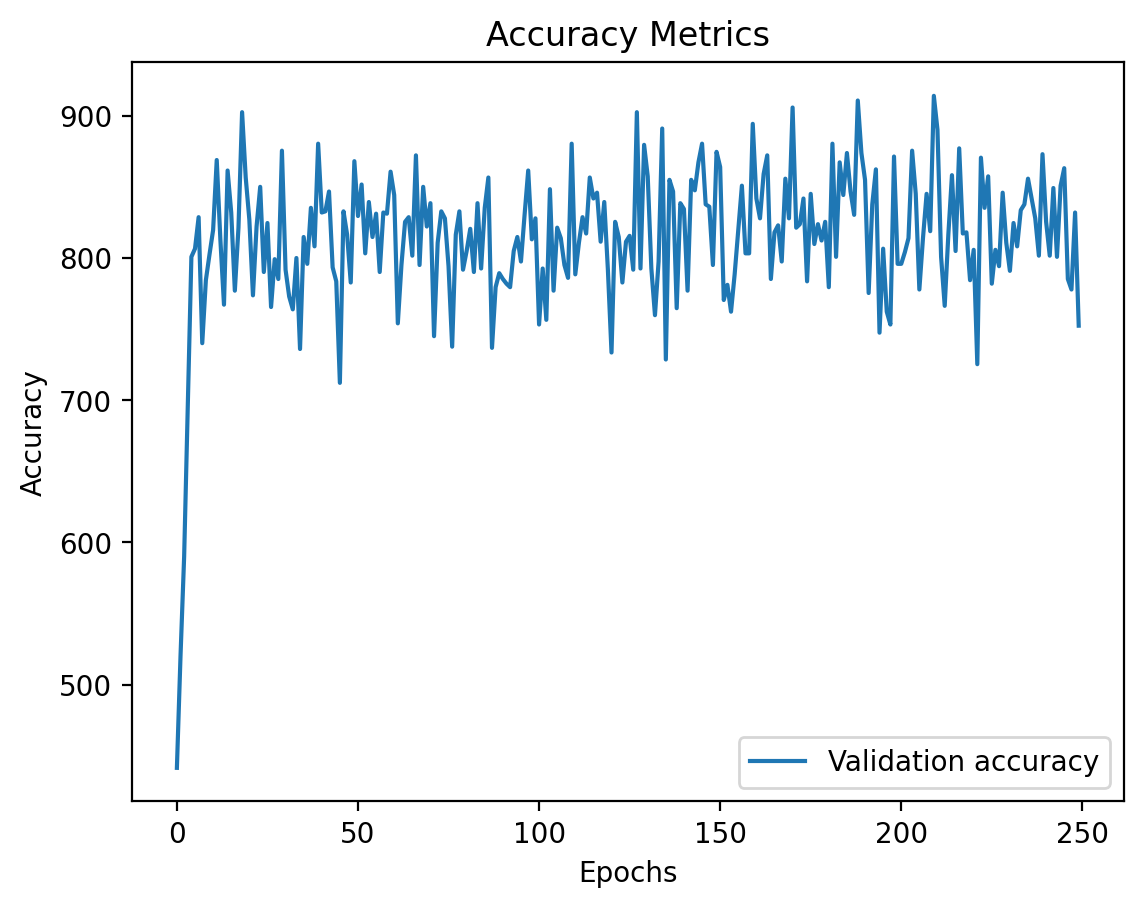

In [43]:
plt.plot([t/test_b*batch_size for t in torch.tensor(test_correct).cpu()], label='Validation accuracy')

plt.title('Accuracy Metrics')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')

plt.legend()
plt.show()

Evaluating: 100%|██████████| 40/40 [00:17<00:00,  2.22it/s]


Model Performance Metrics:
Accuracy:  0.3471
Precision: 0.1041
Recall:    0.1399
F1-score:  0.0984
AUC:       0.4925
Kappa:     0.0586


<Figure size 1000x800 with 0 Axes>

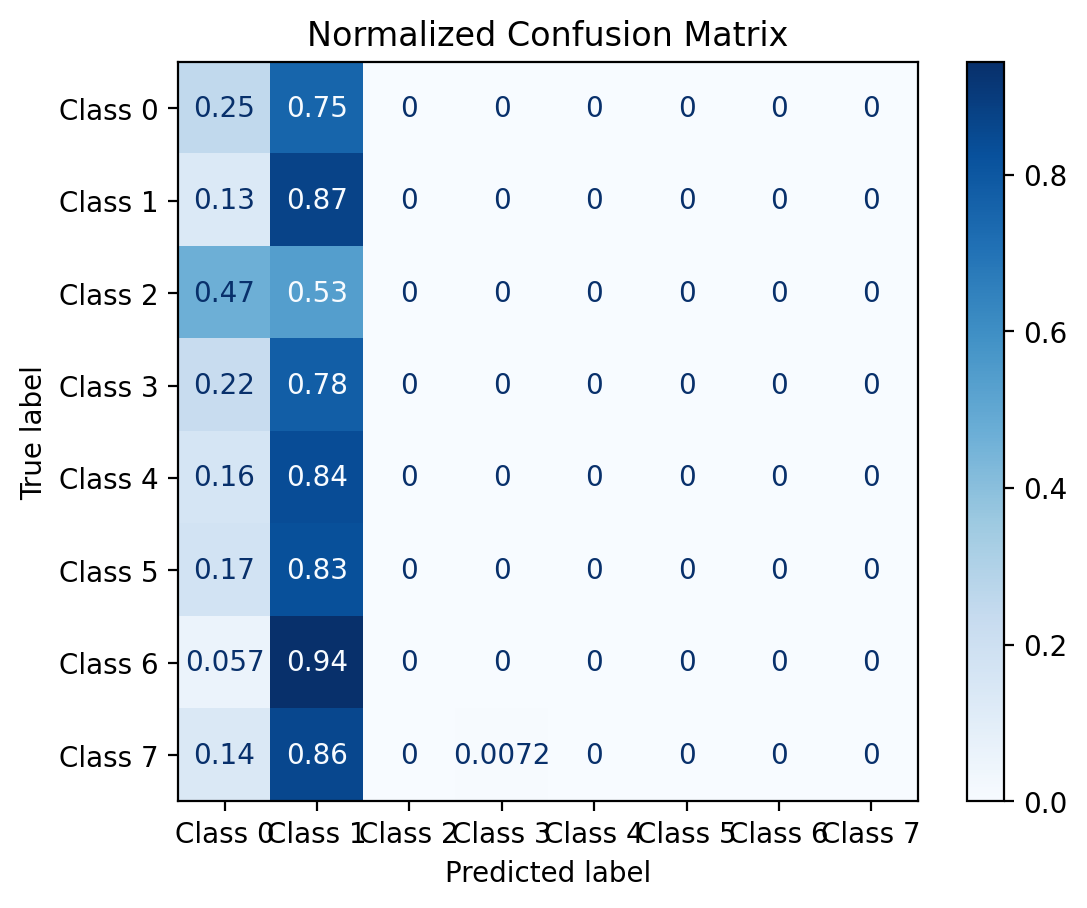

In [44]:
# 在测试集上评估模型并收集预测结果
resnet_model.eval()

all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for sample in tqdm(test_loader, desc='Evaluating'):
        X = sample['image'].to(device, dtype=torch.float)
        y = sample['labels'].to(device, dtype=torch.float)
        
        # 获取真实标签（转换为类别索引）
        y_true = torch.argmax(y, dim=1)
        
        # 前向传播
        outputs = resnet_model(X.view(-1, 3, 512, 512))
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)
        
        # 保存结果到CPU
        all_probs.append(probs.cpu().numpy())
        all_labels.append(y_true.cpu().numpy())
        all_preds.append(preds.cpu().numpy())

# 合并所有批次结果
all_probs = np.concatenate(all_probs)
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

# 计算各项指标
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    cohen_kappa_score
)

acc = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')
auc = roc_auc_score(all_labels, all_probs, multi_class='ovr', average='macro')
kappa = cohen_kappa_score(all_labels, all_preds)

# 打印格式化结果
print(f'Model Performance Metrics:')
print(f'Accuracy:  {acc:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall:    {recall:.4f}')
print(f'F1-score:  {f1:.4f}')
print(f'AUC:       {auc:.4f}')
print(f'Kappa:     {kappa:.4f}')

# 可选：绘制混淆矩阵
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay.from_predictions(
    all_labels,
    all_preds,
    cmap='Blues',
    normalize='true',
    display_labels=[f'Class {i}' for i in range(8)]
)
plt.title('Normalized Confusion Matrix')
plt.show()